In [98]:
# !pip install sdv
# !pip install imblearn
# !pip install python-Levenshtein

<h2><strong>1. Import the required libraries

In [100]:
import numpy as np
import pandas as pd
import json
import io

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy import stats
from scipy.stats import chi2_contingency

# Show all columns
pd.set_option('display.max_columns', None)

# Stop warnings
import warnings
warnings.filterwarnings('ignore')

<h2><strong>2. Loading the Dataset

In [102]:
from google.colab import drive
drive.mount('/content/drive')

In [103]:
# Medication Table
file_path1 = '/content/drive/My Drive/pangea dataset/MEDICATION_DATA_TABLE.csv'

# Test Table
file_path2 = '/content/drive/My Drive/pangea dataset/TEST_DATA_TABLE.csv'

# Visits Table
file_path3 = '/content/drive/My Drive/pangea dataset/VISITS_DATA_TABLE.csv'


In [104]:
# Local reading
medication_data = pd.read_csv("MEDICATION_DATA_TABLE.csv",low_memory=False)
test_data = pd.read_csv("TEST_DATA_TABLE.csv",low_memory=False)
visits_data = pd.read_csv("VISITS_DATA_TABLE.csv",low_memory=False)

# Reading from google drive
medication_data = pd.read_csv(file_path1,low_memory=False)
test_data = pd.read_csv(file_path2,low_memory=False)
visits_data = pd.read_csv(file_path3,low_memory=False)

In [106]:
# Unnecessary column
medication_data.drop(columns=['EXPIRATION_DATE'], inplace=True)
test_data.drop(columns=['EXPIRATION_DATE'], inplace=True)
visits_data.drop(columns=['EXPIRATION_DATE'], inplace=True)

In [107]:
visits_data.head()

,PATIENTID,VISITDATE,VISITTYPECODE,NOWPREGNANT,FAMILYPLANNINGID,FUNCTIONALSTATUSCODE,WHOSTAGE,TBSTATUSCODE,IPTREASONCODE,ARVSTATUSCODE,ARVREASONCODE,ARVCODE,NOTES,STAFFID,USERNUMBER,THETIMESTAMP,IMPORTFILE,facility,ENTRY_DATE
0,00-0A-00-2004-A-00196,29-Nov-21,P,N,NaN,A,2.0,Y,NaN,4.0,422.0,52.0,NaN,2077,1860,15-Apr-15,309261,1344,4-Jun-17
1,00-0A-00-2004-A-00196,9-Jun-15,P,N,NaN,A,2.0,Y,NaN,3.0,NaN,26.0,NaN,2075,1873,10-Jun-15,309261,1344,4-Jun-17
2,00-0A-00-2004-A-00196,15-Jun-15,P,N,NaN,A,2.0,Y,NaN,3.0,NaN,26.0,NaN,2101,1860,17-Jun-15,309261,1344,4-Jun-17
3,00-0A-00-2004-A-00196,6-Aug-15,P,N,C,A,2.0,Y,NaN,3.0,NaN,26.0,NaN,2075,1872,8-Aug-15,309261,1344,4-Jun-17
4,00-0A-00-2004-A-00196,6-Oct-15,P,N,NaN,A,2.0,Y,NaN,3.0,NaN,26.0,NaN,2095,1860,7-Oct-15,309261,1344,4-Jun-17


In [108]:
test_data.head()

,ID,PATIENTID,TESTTYPEID,TESTDATE,RESULTDATE,RESULTNUMERIC,RESULTNOTES,IMPORTFILE,FACILITY,ENTRY_DATE
0,416776,03-09-26-2007-A-02479,WGT,06-JUL-2015,06-JUL-2015,31.0,NaN,0309261,1344,04-JUN-2017
1,416777,03-09-26-2007-A-02479,WGT,08-SEP-2015,08-SEP-2015,35.0,NaN,0309261,1344,04-JUN-2017
2,416778,03-09-26-2007-A-02479,WGT,06-NOV-2015,06-NOV-2015,34.0,NaN,0309261,1344,04-JUN-2017
3,416779,03-09-26-2007-A-02479,WGT,06-JAN-2016,06-JAN-2016,35.0,NaN,0309261,1344,04-JUN-2017
4,416780,03-09-26-2007-A-02479,WGT,04-MAR-2016,04-MAR-2016,33.5,NaN,0309261,1344,04-JUN-2017


In [109]:
medication_data.head()

,PATIENTID,VISITDATE,DRUGTYPEID,QUANTITYDISPENSED,PERCENTADHERENCE,NOTES,IMPORTFILE,FACILITY,ENTRY_DATE
0,03-09-26-2007-A-00725,14-JUN-2007,ARV,14.0,NaN,NaN,0309261,1344,04-JUN-2017
1,03-09-26-2007-A-00725,14-JUN-2007,COT,14.0,100.0,NaN,0309261,1344,04-JUN-2017
2,03-09-26-2007-A-00725,20-JUN-2013,ARV,60.0,100.0,NaN,0309261,1344,04-JUN-2017
3,03-09-26-2007-A-00725,20-JUN-2013,COT,60.0,100.0,NaN,0309261,1344,04-JUN-2017
4,03-09-26-2007-A-00725,30-MAY-2014,ARV,60.0,100.0,NaN,0309261,1344,04-JUN-2017


**Considering that computing power is limited we decided to sample 10000 unique patients**

In [111]:
np.random.seed(42)

unique_patient_ids = visits_data['PATIENTID'].unique()
print('Number of unique Patients:', len(unique_patient_ids))
sampled_patient_ids = np.random.choice(unique_patient_ids, size=10000, replace=False)

visits_data = visits_data[visits_data['PATIENTID'].isin(sampled_patient_ids)]
medication_data = medication_data[medication_data['PATIENTID'].isin(sampled_patient_ids)]
test_data = test_data[test_data['PATIENTID'].isin(sampled_patient_ids)]


Number of unique Patients: 93274


<h2><strong> 3. DATA PREPARATION AND EXPLORATORY DATA ANALYSIS

In [113]:
visits_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88958 entries, 692 to 824865
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PATIENTID             88958 non-null  object 
 1   VISITDATE             88958 non-null  object 
 2   VISITTYPECODE         88958 non-null  object 
 3   NOWPREGNANT           88958 non-null  object 
 4   FAMILYPLANNINGID      56711 non-null  object 
 5   FUNCTIONALSTATUSCODE  88738 non-null  object 
 6   WHOSTAGE              88638 non-null  float64
 7   TBSTATUSCODE          87322 non-null  object 
 8   IPTREASONCODE         2578 non-null   float64
 9   ARVSTATUSCODE         88944 non-null  float64
 10  ARVREASONCODE         18457 non-null  float64
 11  ARVCODE               85473 non-null  float64
 12  NOTES                 548 non-null    object 
 13  STAFFID               88958 non-null  int64  
 14  USERNUMBER            88958 non-null  int64  
 15  THETIMESTAMP         

In [114]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75335 entries, 0 to 702030
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             75335 non-null  int64  
 1   PATIENTID      75335 non-null  object 
 2   TESTTYPEID     75268 non-null  object 
 3   TESTDATE       75335 non-null  object 
 4   RESULTDATE     72132 non-null  object 
 5   RESULTNUMERIC  74003 non-null  float64
 6   RESULTNOTES    1170 non-null   object 
 7   IMPORTFILE     75335 non-null  object 
 8   FACILITY       75335 non-null  int64  
 9   ENTRY_DATE     75335 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 6.3+ MB


In [115]:
medication_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140790 entries, 162 to 1308718
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PATIENTID          140790 non-null  object 
 1   VISITDATE          140790 non-null  object 
 2   DRUGTYPEID         140790 non-null  object 
 3   QUANTITYDISPENSED  135779 non-null  float64
 4   PERCENTADHERENCE   92403 non-null   float64
 5   NOTES              896 non-null     object 
 6   IMPORTFILE         140790 non-null  object 
 7   FACILITY           140790 non-null  int64  
 8   ENTRY_DATE         140790 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 10.7+ MB


###Missing Values


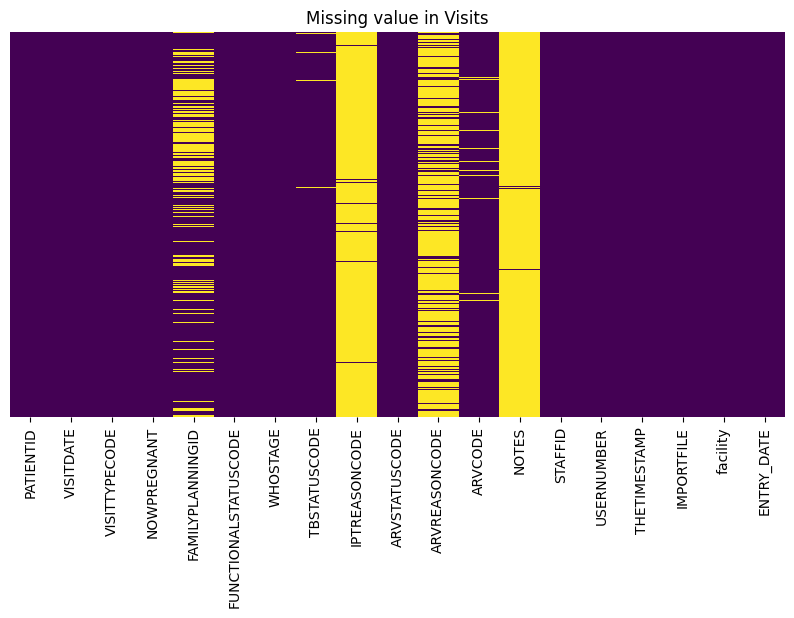

In [117]:
## VISITS
plt.figure(figsize=(10, 5))
sns.heatmap(visits_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing value in Visits')
plt.show()

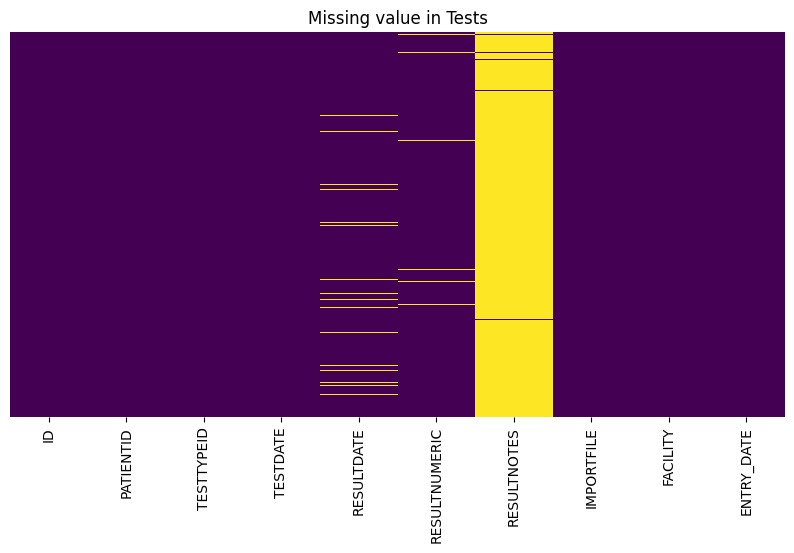

In [118]:
## TESTS
plt.figure(figsize=(10, 5))
sns.heatmap(test_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing value in Tests')
plt.show()

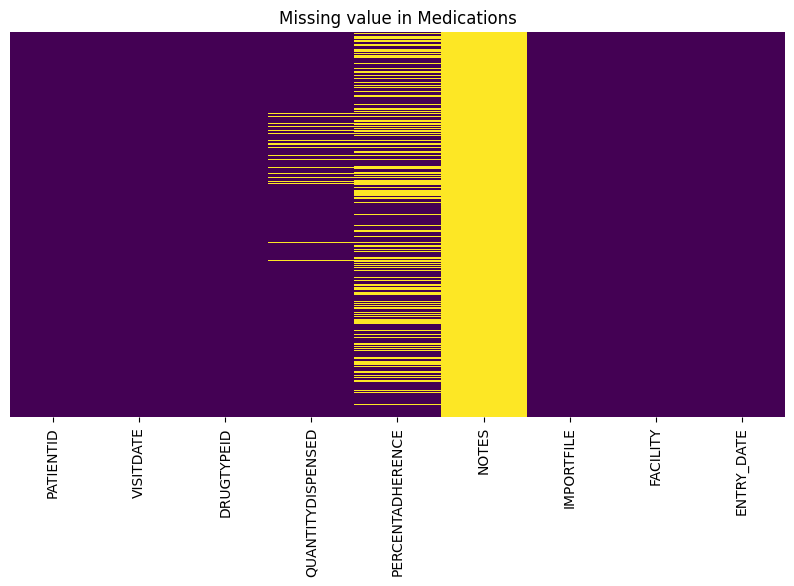

In [119]:
## MEDICATIONS
plt.figure(figsize=(10, 5))
sns.heatmap(medication_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing value in Medications')
plt.show()

In [120]:
## VISITS
missing_values = visits_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / visits_data.shape[0] * 100
missing_values

FAMILYPLANNINGID        36.249691
FUNCTIONALSTATUSCODE     0.247308
WHOSTAGE                 0.359720
TBSTATUSCODE             1.839070
IPTREASONCODE           97.102003
ARVSTATUSCODE            0.015738
ARVREASONCODE           79.252007
ARVCODE                  3.917579
NOTES                   99.383979
dtype: float64

In [121]:
## Missing values percentage - TESTS
missing_values = test_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / test_data.shape[0] * 100
missing_values

TESTTYPEID        0.088936
RESULTDATE        4.251676
RESULTNUMERIC     1.768102
RESULTNOTES      98.446937
dtype: float64

In [122]:
## Missing values percentage - MEDICATIONS
missing_values = medication_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / medication_data.shape[0] * 100
missing_values

QUANTITYDISPENSED     3.559202
PERCENTADHERENCE     34.368208
NOTES                99.363591
dtype: float64


### <h3><strong>Numerical and Categorical Data Segregation</strong></h3>


In [124]:
visits_data.rename(columns={'facility': 'FACILITY'}, inplace=True)

visits_data['FACILITY'] = visits_data['FACILITY'].astype('object')
numerical_columns_visit = visits_data.select_dtypes(include=['number']).columns.tolist()
categorical_columns_visit = visits_data.select_dtypes(include=['object']).columns.tolist()

print("numerical columns:", numerical_columns_visit)
print("categorical columns:", categorical_columns_visit)

numerical columns: ['WHOSTAGE', 'IPTREASONCODE', 'ARVSTATUSCODE', 'ARVREASONCODE', 'ARVCODE', 'STAFFID', 'USERNUMBER']
categorical columns: ['PATIENTID', 'VISITDATE', 'VISITTYPECODE', 'NOWPREGNANT', 'FAMILYPLANNINGID', 'FUNCTIONALSTATUSCODE', 'TBSTATUSCODE', 'NOTES', 'THETIMESTAMP', 'IMPORTFILE', 'FACILITY', 'ENTRY_DATE']


In [125]:
medication_data['FACILITY'] = medication_data['FACILITY'].astype('object')
numerical_columns_medication = medication_data.select_dtypes(include=['number']).columns.tolist()
categorical_columns_medication = medication_data.select_dtypes(include=['object']).columns.tolist()

print("numerical columns:", numerical_columns_medication)
print("categorical columns:", categorical_columns_medication)

numerical columns: ['QUANTITYDISPENSED', 'PERCENTADHERENCE']
categorical columns: ['PATIENTID', 'VISITDATE', 'DRUGTYPEID', 'NOTES', 'IMPORTFILE', 'FACILITY', 'ENTRY_DATE']


In [126]:
test_data['FACILITY'] = test_data['FACILITY'].astype('object')
test_data['ID'] = test_data['ID'].astype('object')
numerical_columns_test = test_data.select_dtypes(include=['number']).columns.tolist()
categorical_columns_test = test_data.select_dtypes(include=['object']).columns.tolist()

print("numerical columns:", numerical_columns_test)
print("categorical columns:", categorical_columns_test)

numerical columns: ['RESULTNUMERIC']
categorical columns: ['ID', 'PATIENTID', 'TESTTYPEID', 'TESTDATE', 'RESULTDATE', 'RESULTNOTES', 'IMPORTFILE', 'FACILITY', 'ENTRY_DATE']


### <h3>Handling problematic values ​​in numeric columns and date columns</h3>


In [128]:
# Search for invalid values ​​in numeric columns
numerical_columns = {
    'visits_data': [],
    'test_data': ['RESULTNUMERIC'],
    'medication_data': ['QUANTITYDISPENSED', 'PERCENTADHERENCE']
}

# Checking numeric columns and finding invalid values
def find_invalid_numerical_values(df, columns):
    invalid_values = {}
    for col in columns:
        if col in df.columns:
            invalid_rows = df[~df[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()]
            if not invalid_rows.empty:
                invalid_values[col] = invalid_rows[col].unique()
    return invalid_values

invalid_visits_data = find_invalid_numerical_values(visits_data, numerical_columns['visits_data'])
invalid_test_data = find_invalid_numerical_values(test_data, numerical_columns['test_data'])
invalid_medication_data = find_invalid_numerical_values(medication_data, numerical_columns['medication_data'])

print("Invalid numerical values in visits_data:")
print(invalid_visits_data)

print("Invalid numerical values in test_data:")
print(invalid_test_data)

print("Invalid numerical values in medication_data:")
print(invalid_medication_data)

Invalid numerical values in visits_data:
{}
Invalid numerical values in test_data:
{'RESULTNUMERIC': array([nan])}
Invalid numerical values in medication_data:
{'QUANTITYDISPENSED': array([nan]), 'PERCENTADHERENCE': array([nan])}


In [129]:
# Handle invalid values ​​in numeric columns
# Cleaning invalid values ​​from numeric columns by converting them to 0
def clean_numerical_columns(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    return df

visits_data = clean_numerical_columns(visits_data, numerical_columns['visits_data'])
test_data = clean_numerical_columns(test_data, numerical_columns['test_data'])
medication_data = clean_numerical_columns(medication_data, numerical_columns['medication_data'])


In [130]:
# Converting Date columns to uniform format
def convert_dates(df, date_columns):
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col].astype(str).str.upper(), errors='coerce')
    return df

date_columns = ['VISITDATE', 'THETIMESTAMP', 'ENTRY_DATE', 'TESTDATE', 'RESULTDATE']

visits_data = convert_dates(visits_data, date_columns)
test_data = convert_dates(test_data, date_columns)
medication_data = convert_dates(medication_data, date_columns)

In [131]:
list(visits_data['ENTRY_DATE'].unique()[:5])

[Timestamp('2017-06-04 00:00:00'),
 Timestamp('2017-05-14 00:00:00'),
 Timestamp('2017-05-11 00:00:00'),
 Timestamp('2017-07-11 00:00:00'),
 Timestamp('2017-05-28 00:00:00')]

In [132]:
visits_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88958 entries, 692 to 824865
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   PATIENTID             88958 non-null  object        
 1   VISITDATE             88958 non-null  datetime64[ns]
 2   VISITTYPECODE         88958 non-null  object        
 3   NOWPREGNANT           88958 non-null  object        
 4   FAMILYPLANNINGID      56711 non-null  object        
 5   FUNCTIONALSTATUSCODE  88738 non-null  object        
 6   WHOSTAGE              88638 non-null  float64       
 7   TBSTATUSCODE          87322 non-null  object        
 8   IPTREASONCODE         2578 non-null   float64       
 9   ARVSTATUSCODE         88944 non-null  float64       
 10  ARVREASONCODE         18457 non-null  float64       
 11  ARVCODE               85473 non-null  float64       
 12  NOTES                 548 non-null    object        
 13  STAFFID           

In [133]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75335 entries, 0 to 702030
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             75335 non-null  object        
 1   PATIENTID      75335 non-null  object        
 2   TESTTYPEID     75268 non-null  object        
 3   TESTDATE       75335 non-null  datetime64[ns]
 4   RESULTDATE     72132 non-null  datetime64[ns]
 5   RESULTNUMERIC  75335 non-null  float64       
 6   RESULTNOTES    1170 non-null   object        
 7   IMPORTFILE     75335 non-null  object        
 8   FACILITY       75335 non-null  object        
 9   ENTRY_DATE     75335 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 6.3+ MB


In [134]:
medication_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140790 entries, 162 to 1308718
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   PATIENTID          140790 non-null  object        
 1   VISITDATE          140790 non-null  datetime64[ns]
 2   DRUGTYPEID         140790 non-null  object        
 3   QUANTITYDISPENSED  140790 non-null  float64       
 4   PERCENTADHERENCE   140790 non-null  float64       
 5   NOTES              896 non-null     object        
 6   IMPORTFILE         140790 non-null  object        
 7   FACILITY           140790 non-null  object        
 8   ENTRY_DATE         140790 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 10.7+ MB


### <h3><strong>Summary Statistics for Numerical Data</strong></h3>

In [136]:
visits_data[numerical_columns_visit].describe().T

,count,mean,std,min,25%,50%,75%,max
WHOSTAGE,88638.0,2.439755,0.798349,1.0,2.0,3.0,3.0,4.0
IPTREASONCODE,2578.0,3.657874,2.244317,1.0,2.0,2.0,7.0,7.0
ARVSTATUSCODE,88944.0,2.930900,0.922233,1.0,3.0,3.0,3.0,99.0
ARVREASONCODE,18457.0,255.149808,151.309196,11.0,201.0,202.0,421.0,423.0
ARVCODE,85473.0,26.046260,12.727583,1.0,26.0,26.0,27.0,98.0
STAFFID,88958.0,2003.014636,690.495601,170.0,2052.0,2224.0,2400.0,2791.0
USERNUMBER,88958.0,1790.157040,649.716653,90.0,1860.0,1938.0,2149.0,2395.0


In [137]:
medication_data[numerical_columns_medication].describe().T

,count,mean,std,min,25%,50%,75%,max
QUANTITYDISPENSED,140790.0,103.311989,79.160854,-240.0,60.0,90.0,120.0,12096.0
PERCENTADHERENCE,140790.0,66.100909,271.112862,0.0,0.0,100.0,100.0,100100.0


In [138]:
medication_data.groupby('DRUGTYPEID')['QUANTITYDISPENSED'].describe().T

DRUGTYPEID,ARV,COT,FLU,IPT
count,77666.000000,60428.000000,129.000000,2567.000000
mean,96.274908,110.883299,61.465116,140.094663
std,78.592661,61.956679,54.944865,249.060509
min,-240.000000,-190.000000,0.000000,0.000000
25%,60.000000,60.000000,0.000000,90.000000
50%,90.000000,120.000000,60.000000,180.000000
75%,120.000000,180.000000,90.000000,180.000000
max,3090.000000,1220.000000,270.000000,12096.000000


**We noticed some outliers values ​​in QUANTITYDISPENDED since it cannot reflect a negative number because it is the amount of medicine the patient received**

In [140]:
print(f'Total Number of rows: {medication_data.shape[0]}')
print(f'Number of rows with negative values: {len(medication_data[medication_data["QUANTITYDISPENSED"] < 0])}')
print(f'Number of rows with QUANTITYDISPENSED >= 0 or null: {len(medication_data[(medication_data["QUANTITYDISPENSED"] >= 0) | (medication_data["QUANTITYDISPENSED"].isnull())])}')

medication_data = medication_data[(medication_data['QUANTITYDISPENSED'] >= 0) | (medication_data['QUANTITYDISPENSED'].isnull())]

Total Number of rows: 140790
Number of rows with negative values: 2
Number of rows with QUANTITYDISPENSED >= 0 or null: 140788


In [141]:
medication_data.groupby('DRUGTYPEID')['PERCENTADHERENCE'].describe().T

DRUGTYPEID,ARV,COT,FLU,IPT
count,77665.000000,60427.000000,129.000000,2567.000000
mean,65.437005,68.055157,36.434109,41.687963
std,49.050987,409.907061,48.312111,49.236862
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,100.000000,100.000000,0.000000,0.000000
75%,100.000000,100.000000,100.000000,100.000000
max,1400.000000,100100.000000,100.000000,100.000000


**We noticed some outliers values ​​in PERCENTADHERENCE column since it should reflect maximum value of 100**

In [143]:
print(f'Total Number of rows: {medication_data.shape[0]}')
print(f'Number of rows with PERCENTADHERENCE <= 100 or null: {len(medication_data[(medication_data["PERCENTADHERENCE"] <= 100) | (medication_data["PERCENTADHERENCE"].isnull())])}')

medication_data = medication_data[(medication_data['PERCENTADHERENCE'] <= 100) | (medication_data['PERCENTADHERENCE'].isnull())]

Total Number of rows: 140788
Number of rows with PERCENTADHERENCE <= 100 or null: 140645


In [144]:
test_data[numerical_columns_test].describe().T

,count,mean,std,min,25%,50%,75%,max
RESULTNUMERIC,75335.0,414.991252,36578.66699,-70.0,52.0,63.0,81.0,9000000.0


In [145]:
test_data.groupby('TESTTYPEID')['RESULTNUMERIC'].describe().T

TESTTYPEID,ALT,BPD,BPS,CD%,CD4,HBX,HGC,HGM,OTH,PUL,RES,TMP,VRL,WBC,WGT
count,289.000000,738.000000,409.000000,176.000000,11022.000000,606.000000,3480.000000,526.000000,631.000000,531.000000,412.000000,876.000000,1.123000e+03,145.000000,54304.000000
mean,30.615709,92.796409,109.872861,180.349264,404.458447,14.143300,146.752253,39.163386,52.752742,82.549209,22.165049,37.842158,2.021147e+04,13.602966,60.614537
std,35.031482,26.473893,25.768644,306.404161,323.576604,16.279056,41.238636,79.402478,869.287126,57.671012,12.415434,25.127028,2.990586e+05,39.410265,31.417502
min,0.900000,0.000000,0.000000,2.800000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-70.000000
25%,16.000000,70.000000,100.000000,20.967500,186.000000,10.200000,132.000000,1.600000,0.000000,74.000000,18.000000,36.000000,0.000000e+00,4.000000,52.000000
50%,22.200000,93.000000,110.000000,35.050000,347.000000,11.700000,158.000000,1.680000,11.600000,80.000000,20.000000,36.000000,9.000000e+00,5.100000,60.000000
75%,34.000000,110.000000,120.000000,271.250000,554.000000,13.200000,166.000000,1.835000,15.000000,88.000000,22.000000,36.300000,4.550000e+01,6.870000,69.000000
max,371.000000,190.000000,307.000000,2260.000000,10096.000000,155.000000,1678.000000,1054.000000,21839.000000,1333.000000,186.000000,358.000000,9.000000e+06,420.000000,1074.000000


In [146]:
def print_unique_values(df, categorical_columns, df_name):
    print(f"Number of unique values - {df_name}:")
    for column in categorical_columns:
        unique_values = df[column].nunique()
        print(f"{column}: {unique_values} unique values")
    print("\n")

print_unique_values(medication_data, categorical_columns_medication, 'medication_data')
print_unique_values(test_data, categorical_columns_test, 'test_data')
print_unique_values(visits_data, categorical_columns_visit, 'visits_data')

Number of unique values - medication_data:
PATIENTID: 9729 unique values
VISITDATE: 3235 unique values
DRUGTYPEID: 4 unique values
NOTES: 189 unique values
IMPORTFILE: 39 unique values
FACILITY: 38 unique values
ENTRY_DATE: 28 unique values


Number of unique values - test_data:
ID: 75335 unique values
PATIENTID: 9564 unique values
TESTTYPEID: 15 unique values
TESTDATE: 3292 unique values
RESULTDATE: 3063 unique values
RESULTNOTES: 497 unique values
IMPORTFILE: 40 unique values
FACILITY: 38 unique values
ENTRY_DATE: 29 unique values


Number of unique values - visits_data:
PATIENTID: 10000 unique values
VISITDATE: 3334 unique values
VISITTYPECODE: 4 unique values
NOWPREGNANT: 2 unique values
FAMILYPLANNINGID: 8 unique values
FUNCTIONALSTATUSCODE: 3 unique values
TBSTATUSCODE: 4 unique values
NOTES: 355 unique values
THETIMESTAMP: 1139 unique values
IMPORTFILE: 45 unique values
FACILITY: 38 unique values
ENTRY_DATE: 34 unique values




In [147]:
print('Number of rows in Visit Table:', visits_data.shape[0])
print('Number of rows in Medication Table:', medication_data.shape[0])
print('Number of rows in Test Table:', test_data.shape[0])


Number of rows in Visit Table: 88958
Number of rows in Medication Table: 140645
Number of rows in Test Table: 75335


### <h3><strong>Distribution Analysis of Columns</strong></h3>

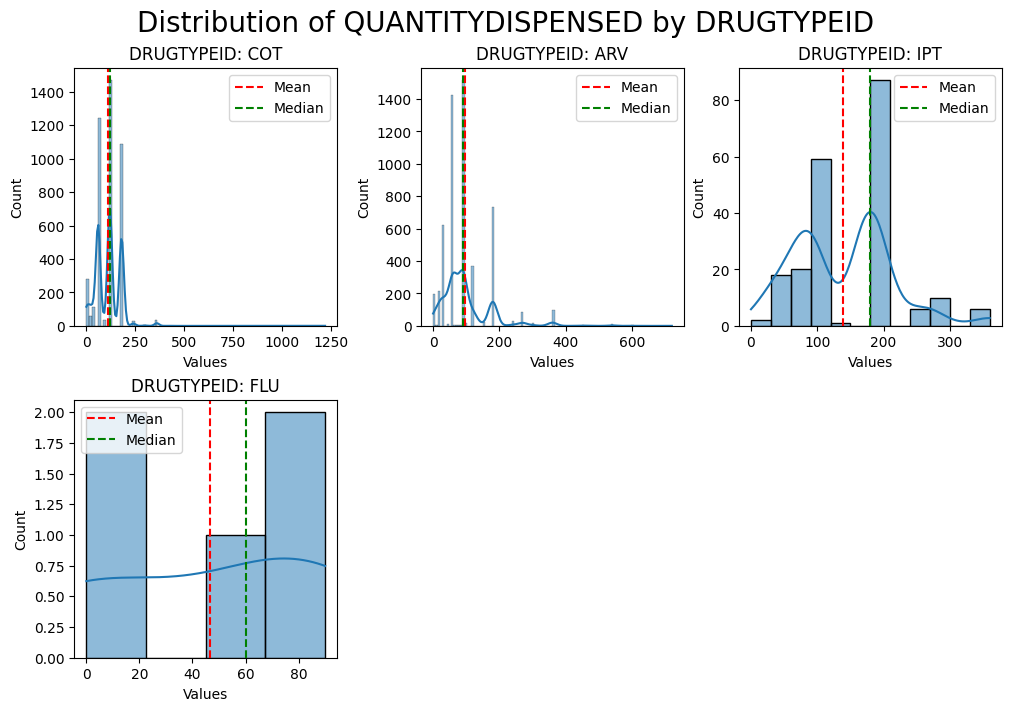

In [149]:
sampled_data = medication_data.sample(n=10000, random_state=42)

drug_types = sampled_data['DRUGTYPEID'].unique()

num_cols = 3
num_rows = (len(drug_types) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7), constrained_layout=True)

for ax, drug_type in zip(axes.flat, drug_types):
    subset = sampled_data[sampled_data['DRUGTYPEID'] == drug_type]['QUANTITYDISPENSED']

    sns.histplot(subset, kde=True, ax=ax)

    mean_value = subset.mean()
    median_value = subset.median()

    ax.axvline(mean_value, color='red', linestyle='--', label='Mean')
    ax.axvline(median_value, color='green', linestyle='--', label='Median')

    ax.set_title(f'DRUGTYPEID: {drug_type}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Count')
    ax.legend()

for ax in axes.flat[len(drug_types):]:
    ax.set_visible(False)

plt.suptitle('Distribution of QUANTITYDISPENSED by DRUGTYPEID', fontsize=20)
plt.show()


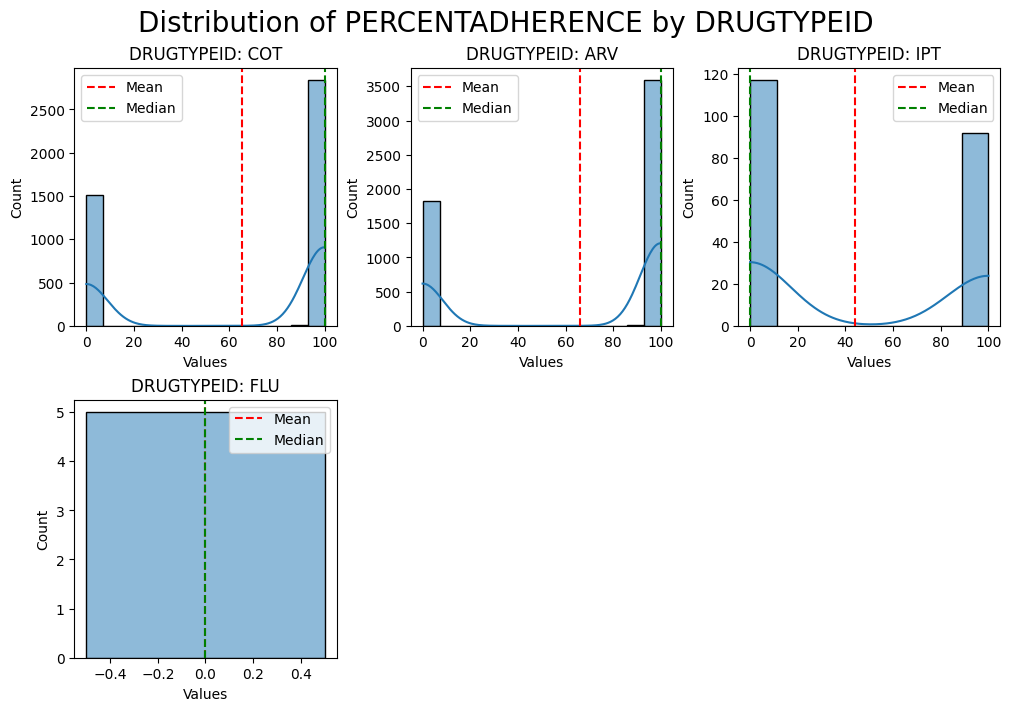

In [150]:
sampled_data = medication_data.sample(n=10000, random_state=42)

drug_types = sampled_data['DRUGTYPEID'].unique()

num_cols = 3
num_rows = (len(drug_types) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7), constrained_layout=True)

for ax, drug_type in zip(axes.flat, drug_types):
    subset = sampled_data[sampled_data['DRUGTYPEID'] == drug_type]['PERCENTADHERENCE']

    sns.histplot(subset, kde=True, ax=ax)

    mean_value = subset.mean()
    median_value = subset.median()

    ax.axvline(mean_value, color='red', linestyle='--', label='Mean')
    ax.axvline(median_value, color='green', linestyle='--', label='Median')

    ax.set_title(f'DRUGTYPEID: {drug_type}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Count')
    ax.legend()

for ax in axes.flat[len(drug_types):]:
    ax.set_visible(False)

plt.suptitle('Distribution of PERCENTADHERENCE by DRUGTYPEID', fontsize=20)
plt.show()


**MinMaxScaler to RESULTNUMERIC column**

In [152]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def scale_group(group):
    group['RESULTNUMERIC'] = scaler.fit_transform(group[['RESULTNUMERIC']])
    return group

test_data = test_data.groupby('TESTTYPEID').apply(scale_group).reset_index(drop=True)

In [153]:
test_data.groupby('TESTTYPEID')['RESULTNUMERIC'].describe().T

TESTTYPEID,ALT,BPD,BPS,CD%,CD4,HBX,HGC,HGM,OTH,PUL,RES,TMP,VRL,WBC,WGT
count,289.000000,738.000000,409.000000,176.000000,11022.000000,606.000000,3480.000000,526.000000,631.000000,531.000000,412.000000,876.000000,1123.000000,145.000000,54304.000000
mean,0.080291,0.488402,0.357892,0.078659,0.040061,0.088306,0.087457,0.037157,0.002416,0.061927,0.119167,0.105704,0.002246,0.032388,0.114174
std,0.094654,0.139336,0.083937,0.135745,0.032050,0.105366,0.024576,0.075334,0.039804,0.043264,0.066750,0.070187,0.033229,0.093834,0.027463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040800,0.368421,0.325733,0.008049,0.018423,0.062783,0.078665,0.001518,0.000000,0.055514,0.096774,0.100559,0.000000,0.009524,0.106643
50%,0.057552,0.489474,0.358306,0.014288,0.034370,0.072492,0.094160,0.001594,0.000531,0.060015,0.107527,0.100559,0.000001,0.012143,0.113636
75%,0.089435,0.578947,0.390879,0.118931,0.054873,0.082201,0.098927,0.001741,0.000687,0.066017,0.118280,0.101397,0.000005,0.016357,0.121503
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


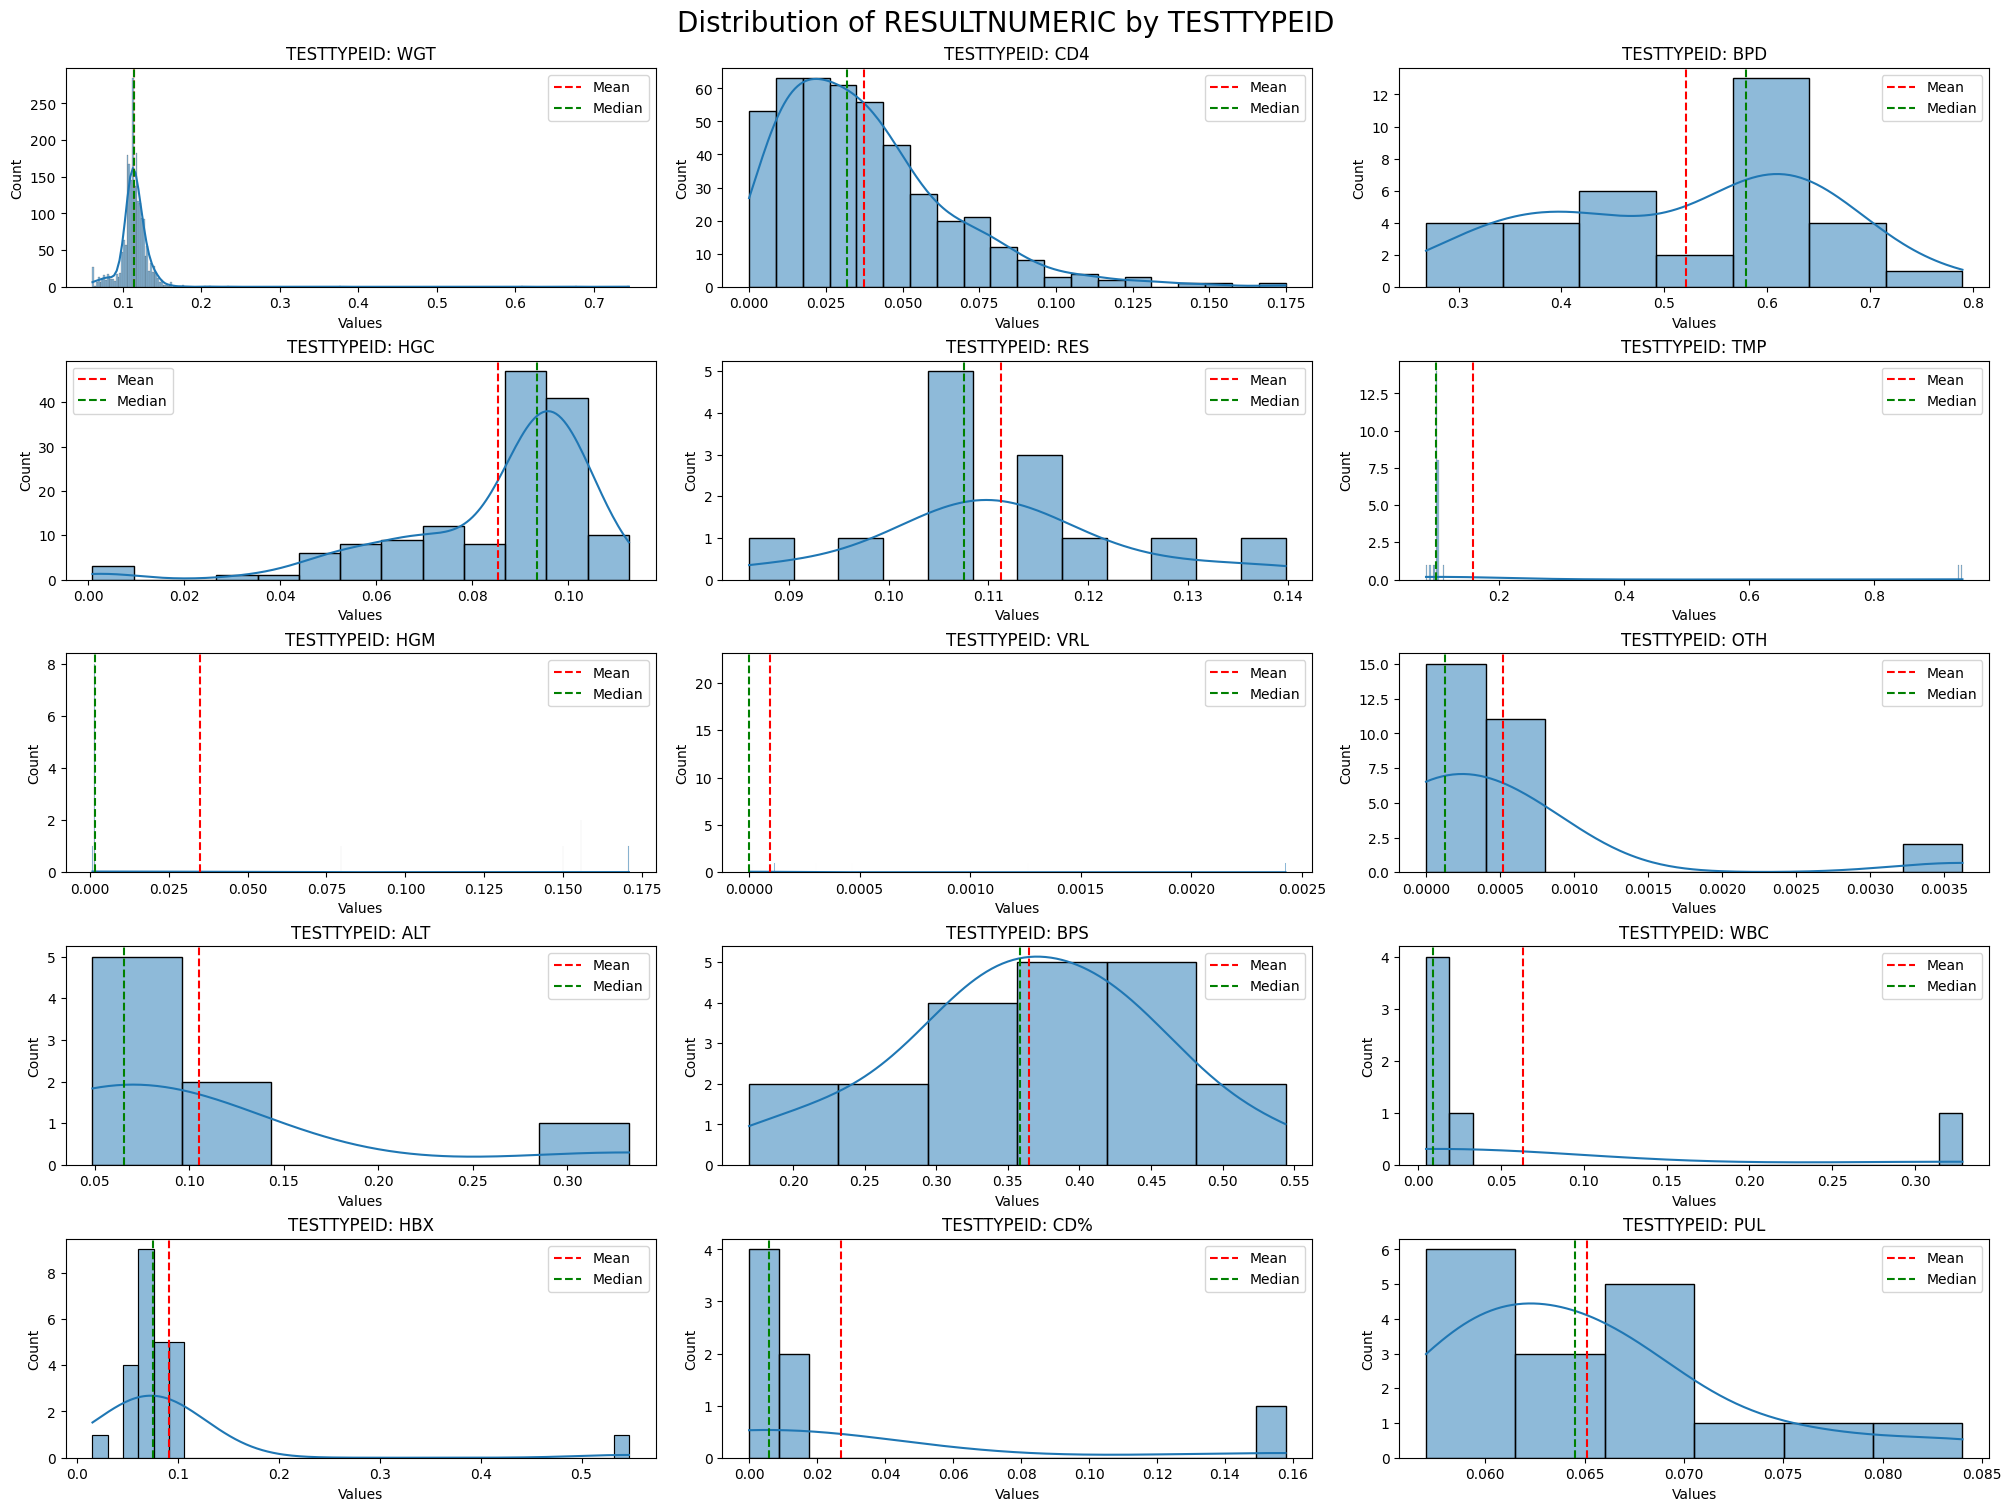

In [154]:
sampled_data = test_data.sample(n=3000, random_state=42)

test_types = sampled_data['TESTTYPEID'].unique()

num_cols = 3
num_rows = (len(test_types) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), constrained_layout=True)

for ax, test_type in zip(axes.flat, test_types):
    subset = sampled_data[sampled_data['TESTTYPEID'] == test_type]['RESULTNUMERIC']

    sns.histplot(subset, kde=True, ax=ax)

    mean_value = subset.mean()
    median_value = subset.median()

    ax.axvline(mean_value, color='red', linestyle='--', label='Mean')
    ax.axvline(median_value, color='green', linestyle='--', label='Median')

    ax.set_title(f'TESTTYPEID: {test_type}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Count')
    ax.legend()

for ax in axes.flat[len(test_types):]:
    ax.set_visible(False)

plt.suptitle('Distribution of RESULTNUMERIC by TESTTYPEID', fontsize=20)
plt.show()


In [155]:
medication_data.groupby('DRUGTYPEID')['PERCENTADHERENCE'].describe().T

DRUGTYPEID,ARV,COT,FLU,IPT
count,77552.000000,60397.000000,129.000000,2567.000000
mean,65.215455,66.183254,36.434109,41.687963
std,47.416235,47.153954,48.312111,49.236862
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,100.000000,100.000000,0.000000,0.000000
75%,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000


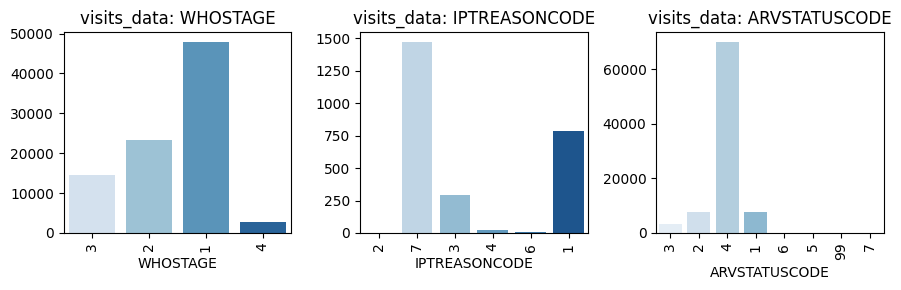

In [156]:
specific_columns = ['WHOSTAGE', 'IPTREASONCODE', 'ARVSTATUSCODE']

plt.figure(figsize=(12, 3))
for i, col in enumerate(specific_columns):
    plt.subplot((len(specific_columns) // 4) + 1, 4, i+1)
    values = visits_data[col].value_counts().values
    labels = visits_data[col].value_counts().index
    colors = sns.color_palette("Blues", len(labels))

    sns.barplot(x=labels, y=values, palette=colors)
    plt.title(f"visits_data: {col}")
    plt.xticks(rotation=90)

    plt.gca().set_xticklabels(labels.astype(int))
    #plt.savefig(f'{col}_distribution.png')

plt.tight_layout()
plt.show()

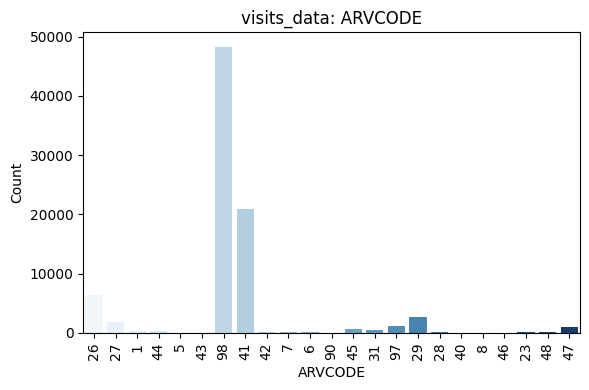

In [157]:
plt.figure(figsize=(6, 4))
values = visits_data['ARVCODE'].value_counts().values
labels = visits_data['ARVCODE'].value_counts().index
colors = sns.color_palette("Blues", len(labels))

sns.barplot(x=labels, y=values, palette=colors)
plt.title('visits_data: ARVCODE')
plt.xlabel('ARVCODE')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().set_xticklabels(labels.astype(int))
plt.tight_layout()

#plt.savefig(f'ARVCODE_distribution.png')
plt.show()

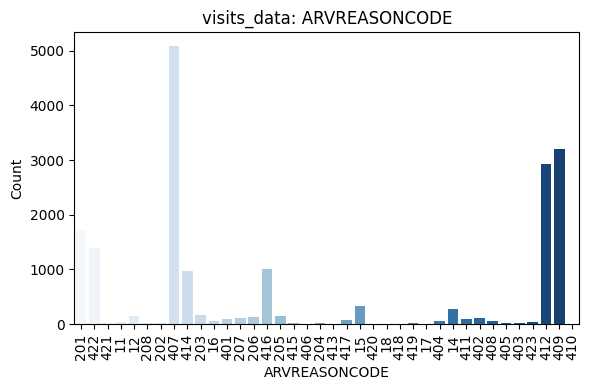

In [158]:
plt.figure(figsize=(6, 4))
values = visits_data['ARVREASONCODE'].value_counts().values
labels = visits_data['ARVREASONCODE'].value_counts().index
colors = sns.color_palette("Blues", len(labels))

sns.barplot(x=labels, y=values, palette=colors)
plt.title('visits_data: ARVREASONCODE')
plt.xlabel('ARVREASONCODE')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().set_xticklabels(labels.astype(int))
plt.tight_layout()

#plt.savefig(f'ARVREASONCODE_distribution.png')
plt.show()

Number of unique values: 597



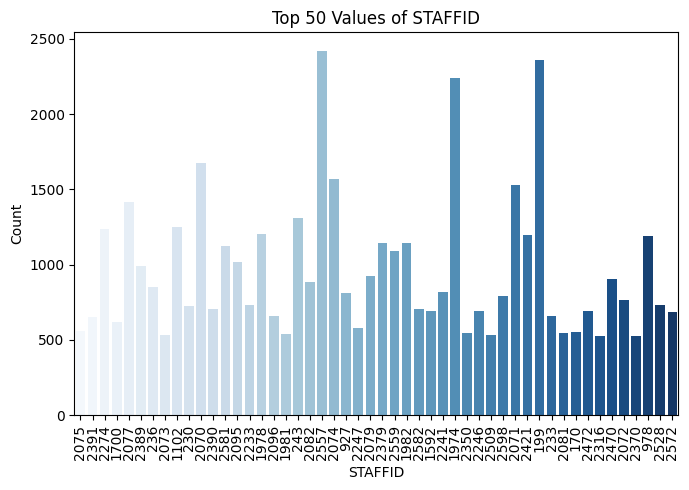

In [159]:
# Displaying the top 50 most frequent values because there are 597 unique values, making the plot more readable
print(f"Number of unique values: {visits_data['STAFFID'].nunique()}\n")

top_n = 50
top_values = visits_data['STAFFID'].value_counts().nlargest(top_n)

plt.figure(figsize=(7, 5))
colors = sns.color_palette("Blues", top_n)

sns.barplot(x=top_values.index, y=top_values.values, palette=colors)
plt.title('Top 50 Values of STAFFID')
plt.xlabel('STAFFID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().set_xticklabels(top_values.index.astype(int))
plt.tight_layout()

#plt.savefig('STAFFID_top_50_distribution.png')

plt.show()


Number of unique values: 276



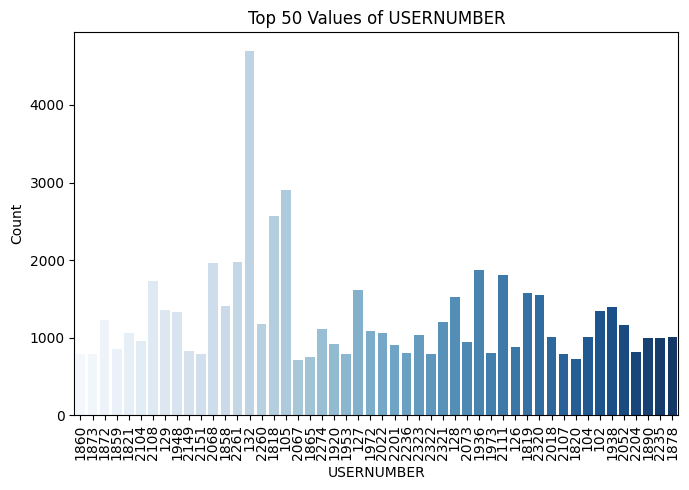

In [160]:
# Displaying the top 50 most frequent values because there are 276 unique values, making the plot more readable
print(f"Number of unique values: {visits_data['USERNUMBER'].nunique()}\n")

top_values = visits_data['USERNUMBER'].value_counts().nlargest(top_n)

plt.figure(figsize=(7, 5))
colors = sns.color_palette("Blues", top_n)

sns.barplot(x=top_values.index, y=top_values.values, palette=colors)
plt.title('Top 50 Values of USERNUMBER')
plt.xlabel('USERNUMBER')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().set_xticklabels(top_values.index.astype(int))
plt.tight_layout()

#plt.savefig('USERNUMBER_top_50_distribution.png')

plt.show()


In [161]:
categorical_df = pd.DataFrame({
    'Medications': pd.Series(categorical_columns_medication),
    'Tests': pd.Series(categorical_columns_test),
    'Visits': pd.Series(categorical_columns_visit)
})

categorical_df.fillna("-", inplace=True)
categorical_df

,Medications,Tests,Visits
0,PATIENTID,ID,PATIENTID
1,VISITDATE,PATIENTID,VISITDATE
2,DRUGTYPEID,TESTTYPEID,VISITTYPECODE
3,NOTES,TESTDATE,NOWPREGNANT
4,IMPORTFILE,RESULTDATE,FAMILYPLANNINGID
5,FACILITY,RESULTNOTES,FUNCTIONALSTATUSCODE
6,ENTRY_DATE,IMPORTFILE,TBSTATUSCODE
7,-,FACILITY,NOTES
8,-,ENTRY_DATE,THETIMESTAMP
9,-,-,IMPORTFILE


In [162]:
def autopct_threshold(pct, threshold=3):
    return ('%1.1f%%' % pct) if pct > threshold else ''

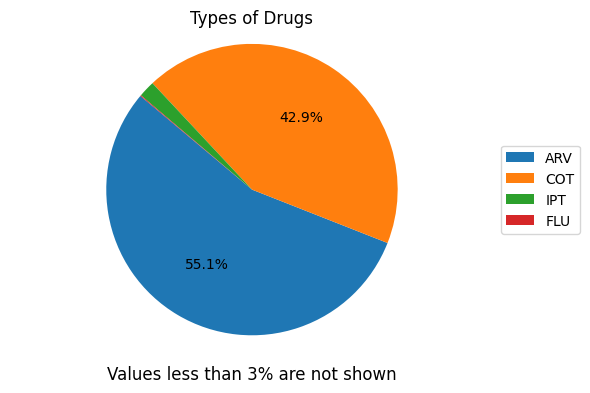

In [163]:
drugtype_counts = medication_data['DRUGTYPEID'].value_counts()
labels = drugtype_counts.index
sizes = drugtype_counts.values

plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=None, autopct=lambda pct: autopct_threshold(pct), startangle=140)
plt.title('Types of Drugs')
plt.axis('equal')

plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.text(0, -1.3, 'Values less than 3% are not shown', fontsize=12, ha='center')

plt.tight_layout()
# plt.savefig('types_of_drugs_pie_chart.png')
plt.show()


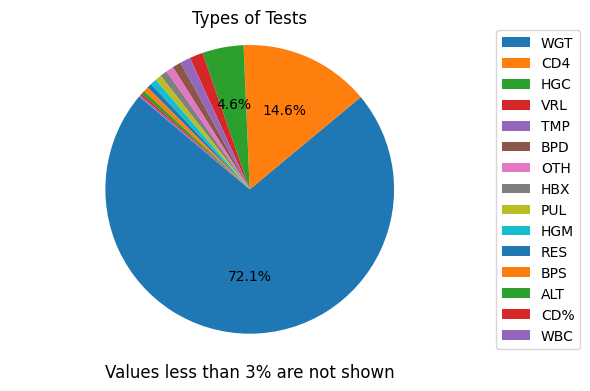

In [164]:
testtype_counts = test_data['TESTTYPEID'].value_counts()
sizes = testtype_counts.values
labels = testtype_counts.index

plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=None, autopct=lambda pct: autopct_threshold(pct), startangle=140)
plt.title('Types of Tests')
plt.axis('equal')

plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.text(0, -1.3, 'Values less than 3% are not shown', fontsize=12, ha='center')

plt.tight_layout()
# plt.savefig('types_of_tests_pie_chart.png')
plt.show()

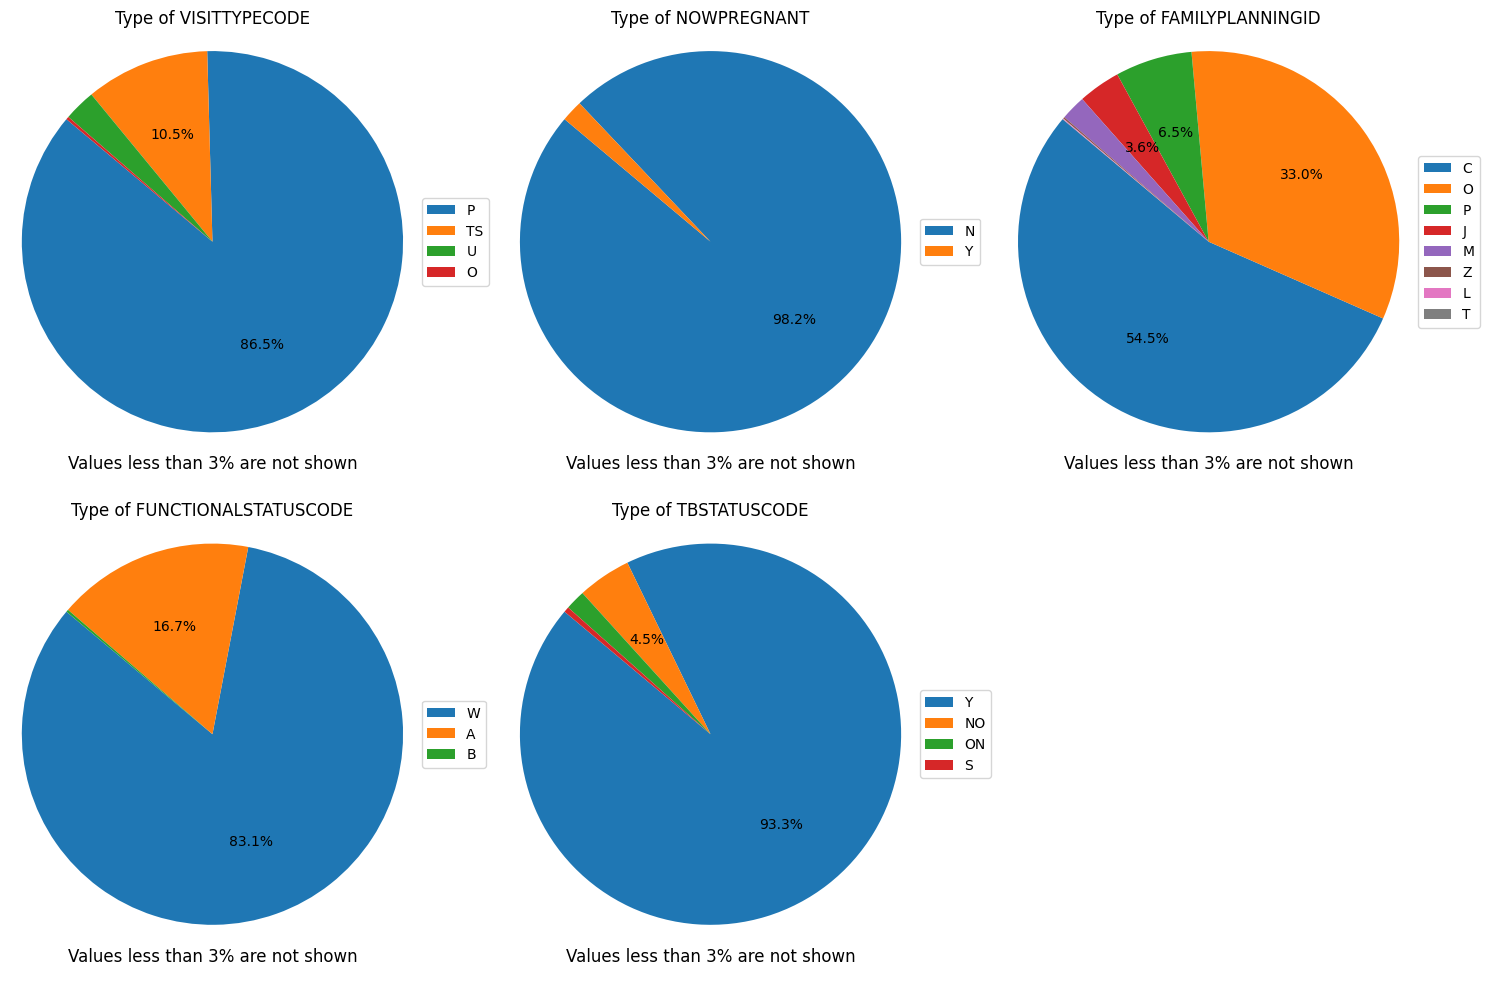

In [165]:
columns_to_plot = ['VISITTYPECODE', 'NOWPREGNANT', 'FAMILYPLANNINGID', 'FUNCTIONALSTATUSCODE', 'TBSTATUSCODE']
num_columns = 3
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

for i, col in enumerate(columns_to_plot):
    row = i // num_columns
    col_idx = i % num_columns
    ax = axes[row, col_idx] if num_rows > 1 else axes[col_idx]

    value_counts = visits_data[col].value_counts()
    labels = value_counts.index
    sizes = value_counts.values

    ax.pie(sizes, labels=None, autopct=lambda pct: autopct_threshold(pct), startangle=140)
    ax.set_title(f'Type of {col}')
    ax.axis('equal')
    ax.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.text(0, -1.3, 'Values less than 3% are not shown\n', fontsize=12, ha='center')

# Hide empty subplots if the number of columns is not a perfect multiple of 3
for j in range(len(columns_to_plot), num_rows * num_columns):
    row = j // num_columns
    col_idx = j % num_columns
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [166]:
visits_data_copy = visits_data.copy()

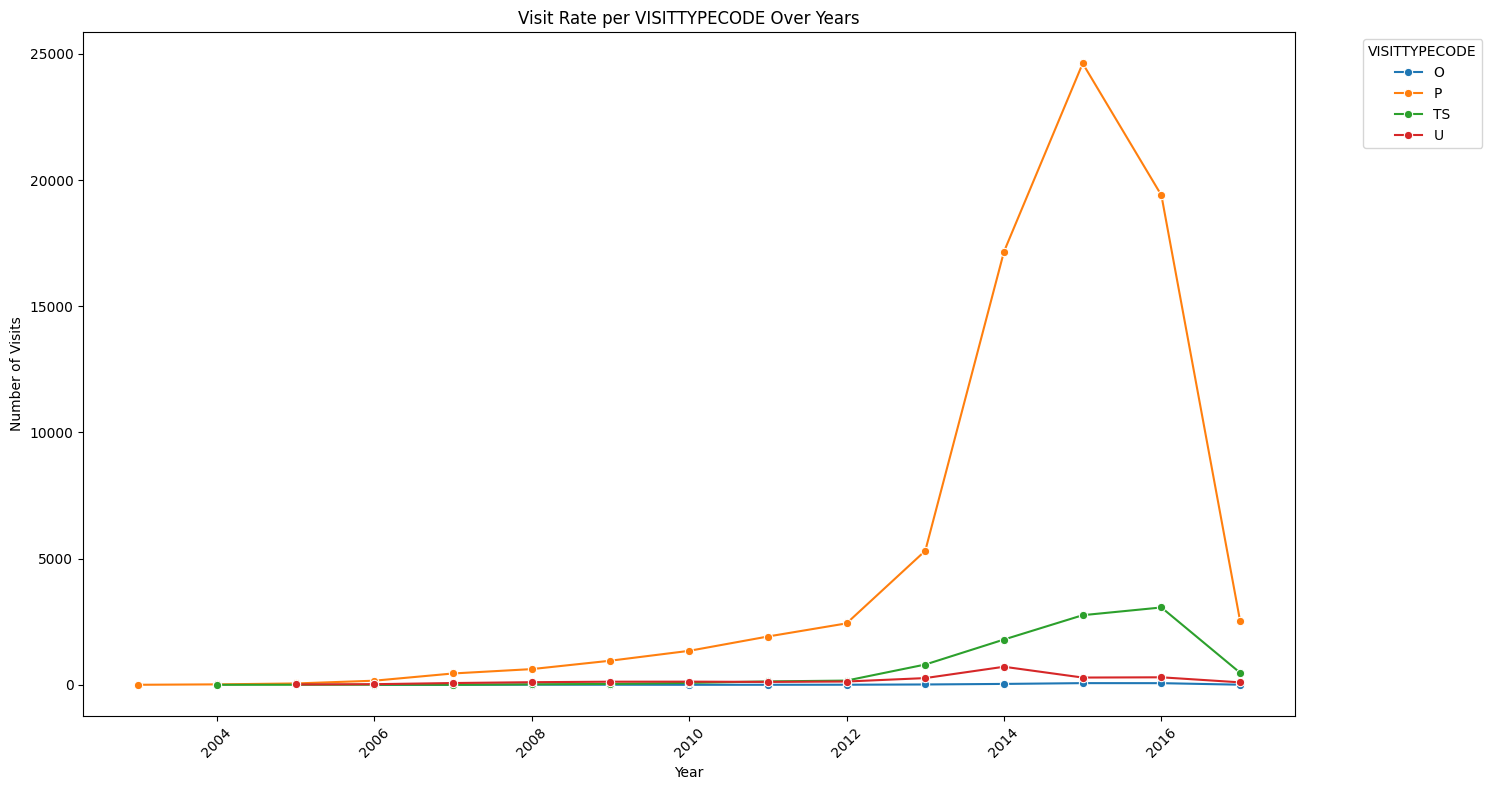

In [167]:
invalid_dates = visits_data_copy[visits_data_copy['VISITDATE'].isna()]

if not invalid_dates.empty:
    print("Found invalid date formats:")
    print(invalid_dates)
else:
    visits_data_copy['Year'] = visits_data_copy['VISITDATE'].dt.year

    visit_counts = visits_data_copy.groupby(['VISITTYPECODE', 'Year']).size().reset_index(name='VisitCount')

    plt.figure(figsize=(15, 8))
    sns.lineplot(data=visit_counts, x='Year', y='VisitCount', hue='VISITTYPECODE', marker='o')

    plt.title('Visit Rate per VISITTYPECODE Over Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Visits')
    plt.xticks(rotation=45)
    plt.legend(title='VISITTYPECODE', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # plt.savefig('average_visit_rate_per_type.png')

    plt.show()



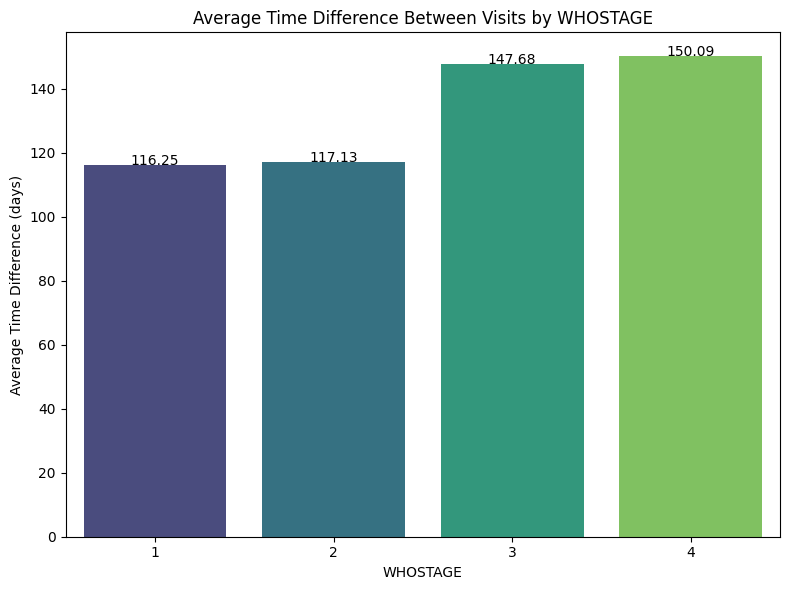

In [168]:
visits_data_copy = visits_data_copy.sort_values(by=['PATIENTID', 'VISITDATE'])

visits_data_copy['TimeDifference'] = visits_data_copy.groupby('PATIENTID')['VISITDATE'].diff().dt.days

average_time_diff = visits_data_copy.groupby('WHOSTAGE')['TimeDifference'].mean().reset_index()
average_time_diff = average_time_diff.dropna()
average_time_diff['WHOSTAGE'] = average_time_diff['WHOSTAGE'].astype(int)

plt.figure(figsize=(8, 6))
sns.barplot(data=average_time_diff, x='WHOSTAGE', y='TimeDifference', palette='viridis')
plt.title('Average Time Difference Between Visits by WHOSTAGE')
plt.xlabel('WHOSTAGE')
plt.ylabel('Average Time Difference (days)')
plt.xticks(rotation=0)

for index, row in average_time_diff.iterrows():
    plt.text(index, row['TimeDifference'], f'{row["TimeDifference"]:.2f}', color='black', ha="center")

plt.tight_layout()
# plt.savefig('average_time_difference_by_whostage.png')

plt.show()


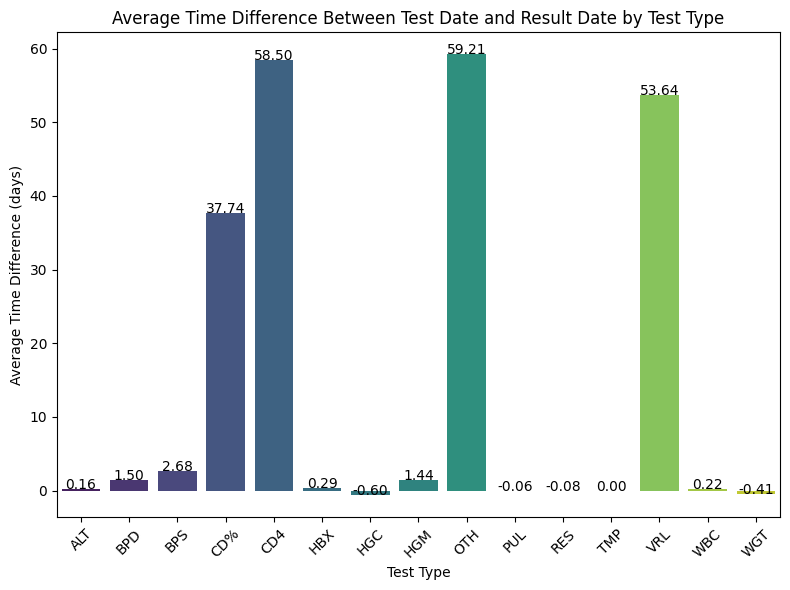

In [169]:
test_data_copy = test_data.copy()

test_data_copy['TimeDifference'] = (test_data_copy['RESULTDATE'] - test_data_copy['TESTDATE']).dt.days
average_time_diff = test_data_copy.groupby('TESTTYPEID')['TimeDifference'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_time_diff, x='TESTTYPEID', y='TimeDifference', palette='viridis')
plt.title('Average Time Difference Between Test Date and Result Date by Test Type')
plt.xlabel('Test Type')
plt.ylabel('Average Time Difference (days)')
plt.xticks(rotation=45)

for index, row in average_time_diff.iterrows():
    plt.text(index, row['TimeDifference'], f'{row["TimeDifference"]:.2f}', color='black', ha="center")

plt.tight_layout()
# plt.savefig('average_time_difference_by_test_type.png')

plt.show()


<h2><strong> 4. The definition of the model, its training and its application


In [171]:
from sdv.metadata import MultiTableMetadata
from sdv.multi_table import HMASynthesizer
from sdv.utils import drop_unknown_references

###<h3><strong>Perform metadata to define relationships between the tables</strong></h3>

In [173]:
metadata = {
    "tables": {
        "visits_data": {
            "primary_key": "PATIENTID_VISITDATE",
            "columns": {
                "PATIENTID": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}"},
                "PATIENTID_VISITDATE": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}_\\d{2}-\\d{2}-\\d{4}"},
                "VISITDATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" },
                "VISITTYPECODE": { "sdtype": "categorical" },
                "NOWPREGNANT": { "sdtype": "categorical" },
                "FAMILYPLANNINGID": { "sdtype": "categorical" },
                "FUNCTIONALSTATUSCODE": { "sdtype": "categorical" },
                "WHOSTAGE": { "sdtype": "categorical" },
                "TBSTATUSCODE": { "sdtype": "categorical" },
                "IPTREASONCODE": { "sdtype": "categorical" },
                "ARVSTATUSCODE": { "sdtype": "categorical" },
                "ARVREASONCODE": { "sdtype": "categorical" },
                "ARVCODE": { "sdtype": "categorical" },
                "NOTES": { "sdtype": "text" },
                "STAFFID": { "sdtype": "categorical" },
                "USERNUMBER": { "sdtype": "categorical" },
                "THETIMESTAMP": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" },
                "IMPORTFILE": { "sdtype": "categorical" },
                "FACILITY": { "sdtype": "categorical" },
                "ENTRY_DATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" }
            }
        },
        "test_data": {
            "primary_key": "ID",
            "columns": {
                "ID": { "sdtype": "id" },
                "PATIENTID_VISITDATE": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}_\\d{2}-\\d{2}-\\d{4}" },
                "PATIENTID_VISITDATE_ID": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}_\\d{2}-\\d{2}-\\d{4}_\\d+" },
                "PATIENTID": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}" },
                "TESTTYPEID": { "sdtype": "categorical" },
                "TESTDATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" },
                "RESULTDATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" },
                "RESULTNUMERIC": { "sdtype": "numerical" },
                "RESULTNOTES": { "sdtype": "text" },
                "IMPORTFILE": { "sdtype": "categorical" },
                "FACILITY": { "sdtype": "categorical" },
                "ENTRY_DATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" }
            }
        },
        "medication_data": {
            "primary_key": "PATIENTID_VISITDATE_DRUGTYPEID",
            "columns": {
                "PATIENTID_VISITDATE": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}_\\d{2}-\\d{2}-\\d{4}" },
                "PATIENTID_VISITDATE_DRUGTYPEID": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}_\\d{2}-\\d{2}-\\d{4}_[A-Z]+" },
                "PATIENTID": { "sdtype": "id", "regex_format": "\\d{2}-\\d{2}-\\d{1}[A-Z]-\\d{4}-[A-Z]-\\d{5}" },
                "VISITDATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" },
                "DRUGTYPEID": { "sdtype": "categorical" },
                "QUANTITYDISPENSED": { "sdtype": "numerical" },
                "PERCENTADHERENCE": { "sdtype": "numerical" },
                "NOTES": { "sdtype": "text" },
                "IMPORTFILE": { "sdtype": "categorical" },
                "FACILITY": { "sdtype": "categorical" },
                "ENTRY_DATE": { "sdtype": "datetime", "datetime_format": "%Y-%m-%d" }
            }
        }
    },
    "relationships": [
        {
            "parent_table_name": "visits_data",
            "child_table_name": "test_data",
            "parent_primary_key": "PATIENTID_VISITDATE",
            "child_foreign_key": "PATIENTID_VISITDATE"
        },
        {
            "parent_table_name": "visits_data",
            "child_table_name": "medication_data",
            "parent_primary_key": "PATIENTID_VISITDATE",
            "child_foreign_key": "PATIENTID_VISITDATE"
        }
    ]
}

with open('metadata.json', 'w') as json_file:
    json.dump(metadata, json_file, indent=4)



In [174]:
# Creating a combined column for a new primary key
visits_data['PATIENTID_VISITDATE'] = visits_data['PATIENTID'].astype(str) + '_' + visits_data['VISITDATE'].astype(str)
medication_data['PATIENTID_VISITDATE'] = medication_data['PATIENTID'].astype(str) + '_' + medication_data['VISITDATE'].astype(str)
test_data['PATIENTID_VISITDATE'] = test_data['PATIENTID'].astype(str) + '_' + test_data['TESTDATE'].astype(str)
medication_data['PATIENTID_VISITDATE_DRUGTYPEID'] = medication_data['PATIENTID'].astype(str) + '_' + medication_data['VISITDATE'].astype(str)+ '_' + medication_data['DRUGTYPEID'].astype(str)
test_data['PATIENTID_VISITDATE_ID'] = test_data['PATIENTID'].astype(str) + '_' + test_data['TESTDATE'].astype(str) + '_' + test_data['ID'].astype(str)

In [175]:
len(test_data['PATIENTID_VISITDATE'].unique())

63427

In [176]:
visits_data = visits_data.drop_duplicates(subset=['PATIENTID_VISITDATE'])

In [177]:
metadata = MultiTableMetadata.load_from_json(filepath="metadata.json")

In [178]:
#Testing if the medication table has duplicate rows in the key
unique_values_count = medication_data['PATIENTID_VISITDATE_DRUGTYPEID'].nunique()
print(f"Number of unique values in PATIENTID: {unique_values_count}")

Number of unique values in PATIENTID: 140636


In [179]:
medication_data = medication_data.drop_duplicates(subset=['PATIENTID_VISITDATE_DRUGTYPEID'])

In [180]:
# Checking that there are as many values ​​as the rows in the table
unique_values_count = medication_data['PATIENTID_VISITDATE_DRUGTYPEID'].nunique()

print(f"Number of unique values in PATIENTID: {unique_values_count}")

Number of unique values in PATIENTID: 140636


In [181]:
medication_data.head()

,PATIENTID,VISITDATE,DRUGTYPEID,QUANTITYDISPENSED,PERCENTADHERENCE,NOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_DRUGTYPEID
162,03-09-26-2007-A-00974,2007-04-25,COT,14.0,0.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2007-04-25,03-09-26-2007-A-00974_2007-04-25_COT
163,03-09-26-2007-A-00974,2009-11-20,COT,30.0,100.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2009-11-20,03-09-26-2007-A-00974_2009-11-20_COT
164,03-09-26-2007-A-00974,2013-10-02,COT,60.0,100.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2013-10-02,03-09-26-2007-A-00974_2013-10-02_COT
165,03-09-26-2007-A-00974,2013-12-12,COT,14.0,100.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2013-12-12,03-09-26-2007-A-00974_2013-12-12_COT
166,03-09-26-2007-A-00974,2014-06-16,COT,60.0,100.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2014-06-16,03-09-26-2007-A-00974_2014-06-16_COT


In [182]:
cleaned_data = drop_unknown_references(
    {
        'visits_data': visits_data,
        'test_data': test_data,
        'medication_data': medication_data
    },
    metadata
)


Success! All foreign keys have referential integrity.

     Table Name  # Rows (Original)  # Invalid Rows  # Rows (New)
medication_data             140636               0        140636
      test_data              75268           12532         62736
    visits_data              88958               0         88958

In [183]:
synthesizer = HMASynthesizer(metadata)
synthesizer.fit(cleaned_data)


Preprocess Tables: 100%|██████████| 3/3 [00:32<00:00, 10.81s/it]



Learning relationships:


(1/2) Tables 'visits_data' and 'medication_data' ('PATIENTID_VISITDATE'): 100%|██████████| 80122/80122 [3:49:46<00:00,  5.81it/s]  
(2/2) Tables 'visits_data' and 'test_data' ('PATIENTID_VISITDATE'): 100%|██████████| 54276/54276 [40:56<00:00, 22.10it/s] 


Modeling Tables: 100%|██████████| 3/3 [09:50<00:00, 196.80s/it]


In [184]:
synthetic_data = synthesizer.sample()

# <h2><strong>5. Model Performance Evaluation: Synthetic vs. Original Data

In [185]:
from sdv.evaluation.multi_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/3) Evaluating Data Validity: |██████████| 43/43 [00:00<00:00, 57.73it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |██████████| 3/3 [00:00<00:00, 153.24it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |██████████| 2/2 [00:00<00:00,  3.71it/s]|
Relationship Validity Score: 100.0%

Overall Score (Average): 100.0%



In [186]:
from sdv.evaluation.multi_table import evaluate_quality
quality_report = evaluate_quality(
    cleaned_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/4) Evaluating Column Shapes: |██████████| 43/43 [00:01<00:00, 23.86it/s]|
Column Shapes Score: 85.83%

(2/4) Evaluating Column Pair Trends: |██████████| 311/311 [00:44<00:00,  7.03it/s]|
Column Pair Trends Score: 54.34%

(3/4) Evaluating Cardinality: |██████████| 2/2 [00:00<00:00,  2.89it/s]|
Cardinality Score: 86.81%

(4/4) Evaluating Intertable Trends: |██████████| 460/460 [00:44<00:00, 10.36it/s]|
Intertable Trends Score: 63.38%

Overall Score (Average): 72.59%



In [187]:
quality_report.get_details('Column Shapes')

,Table,Column,Metric,Score
0,visits_data,VISITDATE,KSComplement,0.925088
1,visits_data,VISITTYPECODE,TVComplement,0.999269
2,visits_data,NOWPREGNANT,TVComplement,0.999494
3,visits_data,FAMILYPLANNINGID,TVComplement,0.997434
4,visits_data,FUNCTIONALSTATUSCODE,TVComplement,0.998855
5,visits_data,WHOSTAGE,TVComplement,0.999015
6,visits_data,TBSTATUSCODE,TVComplement,0.999048
7,visits_data,IPTREASONCODE,TVComplement,0.983239
8,visits_data,ARVSTATUSCODE,TVComplement,0.997292
9,visits_data,ARVREASONCODE,TVComplement,0.986889


## Comparison with SDV model

### Visits Data comparison

In [375]:
synthetic_data['visits_data']

,PATIENTID,VISITDATE,VISITTYPECODE,NOWPREGNANT,FAMILYPLANNINGID,FUNCTIONALSTATUSCODE,WHOSTAGE,TBSTATUSCODE,IPTREASONCODE,ARVSTATUSCODE,ARVREASONCODE,ARVCODE,NOTES,STAFFID,USERNUMBER,THETIMESTAMP,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE
0,00-00-0A-0000-A-81151,2015-07-07,P,N,O,W,3.0,Y,NaN,3.0,NaN,42.0,NaN,2420,2320,2016-04-28,08050A1,728,2017-07-11,00-00-0A-0000-A-00000_00-02-8613
1,00-00-0A-0000-A-00101,2012-08-03,P,N,O,W,3.0,Y,NaN,3.0,NaN,5.0,NaN,1102,1896,2015-01-01,08030A1,1403,2017-06-26,00-00-0A-0000-A-00000_00-00-2421
2,00-00-0A-0000-A-40759,2013-11-30,P,N,C,W,3.0,Y,NaN,3.0,NaN,26.0,NaN,2555,127,2015-04-24,01070A1,1452,2017-05-25,00-00-0A-0000-A-00000_00-02-9019
3,00-00-0A-0000-A-29530,2017-02-08,TS,N,C,W,2.0,Y,NaN,3.0,NaN,27.0,NaN,2436,2068,2016-08-01,08020A1,1183,2017-06-15,00-00-0A-0000-A-00000_00-07-6561
4,00-00-0A-0000-A-37440,2014-10-18,P,N,J,W,1.0,Y,NaN,3.0,NaN,26.0,NaN,173,102,2015-02-26,01040A1,1452,2017-06-18,00-00-0A-0000-A-00000_00-08-2977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88953,00-00-0A-0000-A-85338,2017-02-24,P,N,C,W,3.0,Y,NaN,3.0,NaN,26.0,NaN,2318,1878,2017-05-03,08020D1,189,2017-07-05,00-00-0A-0000-A-00000_00-01-5940
88954,00-00-0A-0000-A-35102,2013-04-29,P,N,NaN,W,2.0,Y,NaN,3.0,NaN,26.0,NaN,233,131,2014-04-28,01040A1,1344,2017-05-18,00-00-0A-0000-A-00000_00-06-4063
88955,00-00-0A-0000-A-63982,2016-01-31,P,N,O,A,3.0,Y,NaN,3.0,NaN,26.0,NaN,2478,2149,2016-12-16,08050A1,728,2017-07-04,00-00-0A-0000-A-00000_00-01-1907
88956,00-00-0A-0000-A-35700,2016-05-20,P,N,C,W,2.0,Y,NaN,3.0,NaN,26.0,NaN,2472,2068,2016-03-30,506281,730,2017-07-11,00-00-0A-0000-A-00000_00-04-7392


## בגלל שהספריה מציגה את הגרפים דרך שרת מסוים בעת פתיחת מחברת הקוד הגרפים של הספריה לא יוצגו,תוכלו לראות אותם בקובץ נפרד

In [191]:
fig_visits_data = quality_report.get_visualization(property_name='Column Shapes', table_name='visits_data')
fig_visits_data.show()

In [192]:
from sdv.evaluation.multi_table import get_column_plot

fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='VISITDATE',
    table_name='visits_data',
    metadata=metadata
)

fig.show()

In [193]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='ENTRY_DATE',
    table_name='visits_data',
    metadata=metadata
)

fig.show()

In [194]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='WHOSTAGE',
    table_name='visits_data',
    metadata=metadata
)

fig.show()

In [195]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='ENTRY_DATE',
    table_name='visits_data',
    metadata=metadata
)

fig.show()

### Medication data comparison

In [379]:
synthetic_data['medication_data']

,PATIENTID,VISITDATE,DRUGTYPEID,QUANTITYDISPENSED,PERCENTADHERENCE,NOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_DRUGTYPEID
0,00-00-0A-0000-A-00000,2015-10-30,FLU,67.0,4.0,Relate test discover soldier wonder. Party act...,0403261,730,2017-07-15,00-00-0A-0000-A-00000_00-02-8613,00-00-0A-0000-A-00000_00-00-0000_A
1,00-00-0A-0000-A-00001,2015-10-30,FLU,76.0,1.0,NaN,0403261,730,2017-07-15,00-00-0A-0000-A-00000_00-02-8613,00-00-0A-0000-A-00000_00-00-0000_B
2,00-00-0A-0000-A-00002,2013-04-18,FLU,113.0,100.0,Fill theory east animal approach international...,0403261,730,2017-07-10,00-00-0A-0000-A-00000_00-00-2421,00-00-0A-0000-A-00000_00-00-0000_C
3,00-00-0A-0000-A-00003,2014-07-30,COT,22.0,40.0,Professor political radio hot leave make.\nWea...,0704631,1623,2017-06-08,00-00-0A-0000-A-00000_00-02-9019,00-00-0A-0000-A-00000_00-00-0000_D
4,00-00-0A-0000-A-00006,2016-11-08,COT,35.0,46.0,NaN,0704631,490,2017-06-12,00-00-0A-0000-A-00000_00-07-6561,00-00-0A-0000-A-00000_00-00-0000_G
...,...,...,...,...,...,...,...,...,...,...,...
140631,00-00-0A-0000-B-40631,2013-11-29,FLU,41.0,94.0,Message person me reason dog good news. Party ...,01070A1,490,2017-05-28,00-00-0A-0000-A-00000_00-06-4063,00-00-0A-0000-A-00000_00-00-0000_GYZX
140632,00-00-0A-0000-B-40632,2016-05-02,ARV,681.0,4.0,Do citizen thing hard support spend five. Char...,01050G1,1403,2017-07-19,00-00-0A-0000-A-00000_00-01-1907,00-00-0A-0000-A-00000_00-00-0000_GYZY
140633,00-00-0A-0000-B-40633,2016-01-05,FLU,226.0,15.0,Develop reality actually three special. Church...,0403261,1187,2017-08-02,00-00-0A-0000-A-00000_00-04-7392,00-00-0A-0000-A-00000_00-00-0000_GYZZ
140634,00-00-0A-0000-B-40634,2016-05-24,FLU,1171.0,36.0,NaN,0403261,130,2017-06-13,00-00-0A-0000-A-00000_00-00-2136,00-00-0A-0000-A-00000_00-00-0000_GZAB


In [221]:
fig_medication_data = quality_report.get_visualization(property_name='Column Shapes', table_name='medication_data')
fig_medication_data.show()

In [222]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='VISITDATE',
    table_name='medication_data',
    metadata=metadata
)

fig.show()

In [223]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='DRUGTYPEID',
    table_name='medication_data',
    metadata=metadata
)

fig.show()

### Test Data comparison

In [381]:
synthetic_data['test_data']

,ID,PATIENTID,TESTTYPEID,TESTDATE,RESULTDATE,RESULTNUMERIC,RESULTNOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_ID
0,sdv-id-aYqHbB,00-00-0A-0000-A-00000,WGT,2016-06-19,2016-06-26,1.0,Near also and course serve. Sport may time tab...,08070A1,324,2017-06-29,00-00-0A-0000-A-00000_00-02-8613,00-00-0A-0000-A-00000_00-00-0000_0
1,sdv-id-uwpxoh,00-00-0A-0000-A-00001,WGT,2014-05-22,2014-03-30,1.0,Theory within rule evidence what. Bank try tho...,08070C1,324,2017-06-04,00-00-0A-0000-A-00000_00-02-9019,00-00-0A-0000-A-00000_00-00-0000_1
2,sdv-id-OTunjj,00-00-0A-0000-A-00002,WGT,2016-06-23,2016-07-16,1.0,Energy type person discuss magazine choice. Le...,309261,189,2017-08-14,00-00-0A-0000-A-00000_00-00-8761,00-00-0A-0000-A-00000_00-00-0000_2
3,sdv-id-PuOyKj,00-00-0A-0000-A-00003,WGT,2015-03-28,2015-04-29,1.0,Pretty war this choose side. Sort image happen...,309261,1344,2017-05-23,00-00-0A-0000-A-00000_00-07-0772,00-00-0A-0000-A-00000_00-00-0000_3
4,sdv-id-czRfmF,00-00-0A-0000-A-00004,WGT,2016-10-13,2016-10-09,1.0,Fly quickly pretty. Large successful let. Beca...,000B031,1395,2017-06-30,00-00-0A-0000-A-00000_00-06-7025,00-00-0A-0000-A-00000_00-00-0000_4
...,...,...,...,...,...,...,...,...,...,...,...,...
62731,sdv-id-nPElaX,00-00-0A-0000-A-62733,WGT,2016-05-28,2016-06-23,1.0,NaN,0704631,1623,2017-07-01,00-00-0A-0000-A-00000_00-01-1907,00-00-0A-0000-A-00000_00-00-0000_51622
62732,sdv-id-wvxkqM,00-00-0A-0000-A-62732,WGT,2016-05-28,2016-06-23,1.0,NaN,07060A1,1183,2017-07-01,00-00-0A-0000-A-00000_00-01-1907,00-00-0A-0000-A-00000_00-00-0000_51624
62733,sdv-id-BZKPRU,00-00-0A-0000-A-62734,WGT,2016-05-28,2016-06-23,1.0,NaN,07060A1,1183,2017-07-01,00-00-0A-0000-A-00000_00-01-1907,00-00-0A-0000-A-00000_00-00-0000_51621
62734,sdv-id-QtcicY,00-00-0A-0000-A-62731,WGT,2016-05-28,2016-06-22,1.0,The seat from particularly particular. Confere...,07060A1,1623,2017-07-01,00-00-0A-0000-A-00000_00-01-1907,00-00-0A-0000-A-00000_00-00-0000_51623


In [225]:
fig_test_data = quality_report.get_visualization(property_name='Column Shapes', table_name='test_data')
fig_test_data.show()

In [219]:
from sdv.evaluation.multi_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_names=['RESULTNUMERIC', 'TESTTYPEID'],
    table_name='test_data',
    metadata=metadata
)

fig.show()

In [226]:
fig = get_column_plot(
    real_data=cleaned_data,
    synthetic_data=synthetic_data,
    column_name='RESULTDATE',
    table_name='test_data',
    metadata=metadata
)

fig.show()

## Comparison without sdv tests

In [228]:
visits_data_synthetic = synthetic_data['visits_data']
test_data_synthetic = synthetic_data['test_data']
medication_data_synthetic = synthetic_data['medication_data']

visits_data_synthetic.to_csv('visits_data_synthetic.csv', header=True, index=False, encoding='utf-8')
test_data_synthetic.to_csv('test_data_synthetic.csv', header=True, index=False, encoding='utf-8')
medication_data_synthetic.to_csv('medication_data_synthetic.csv', header=True, index=False, encoding='utf-8')

print('Export synthetic data tables successfully')

Export synthetic data tables successfully


In [229]:
visits_data_original = cleaned_data['visits_data']
test_data_original = cleaned_data['test_data']
medication_data_original = cleaned_data['medication_data']

visits_data_original.to_csv('visits_data_original.csv', header=True, index=False, encoding='utf-8')
test_data_original.to_csv('test_data_original.csv', header=True, index=False, encoding='utf-8')
medication_data_original.to_csv('medication_data_original.csv', header=True, index=False, encoding='utf-8')

print('Export original data tables successfully')

Export original data tables successfully


### Visits Data comparison

In [316]:
visits_data_original = pd.read_csv("visits_data_original.csv")
test_data_original = pd.read_csv("test_data_original.csv")
medication_data_original = pd.read_csv("medication_data_original.csv")

visits_data_synthetic = pd.read_csv("visits_data_synthetic.csv")
test_data_synthetic = pd.read_csv("test_data_synthetic.csv")
medication_data_synthetic =pd.read_csv("medication_data_synthetic.csv")

Continuous Kullback-Leibler Divergence - עבור ערכים רציפים

In [318]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

def estimate_pdf(data, bandwidth='scott'):
    kde = gaussian_kde(data, bw_method=bandwidth)
    return kde

def kl_divergence(p, q, xmin, xmax):
    integrand = lambda x: p(x) * np.log(p(x) / q(x))
    kl_div, _ = quad(integrand, xmin, xmax)
    return kl_div

def calculate_kl_divergence(df1, df2, column_name):
    data1 = df1[column_name].dropna().values
    data2 = df2[column_name].dropna().values

    pdf1 = estimate_pdf(data1)
    pdf2 = estimate_pdf(data2)

    xmin = min(data1.min(), data2.min())
    xmax = max(data1.max(), data2.max())

    kl_div = kl_divergence(pdf1, pdf2, xmin, xmax)

    print(f"KL Divergence for column '{column_name}': {kl_div}")

calculate_kl_divergence(test_data_original, test_data_synthetic, 'RESULTNUMERIC')
calculate_kl_divergence(medication_data_original, medication_data_synthetic, 'QUANTITYDISPENSED')
calculate_kl_divergence(medication_data_original, medication_data_synthetic, 'PERCENTADHERENCE')

KL Divergence for column 'RESULTNUMERIC': 3.053545966606302
KL Divergence for column 'QUANTITYDISPENSED': nan
KL Divergence for column 'PERCENTADHERENCE': 0.45264029929417693


- KL Divergence is a statistical measure that quantifies the difference between two probability distributions, indicating how one distribution diverges from a second, expected distribution.
- The KL Divergence for the 'RESULTNUMERIC' column is 3.0535, indicating a substantial difference between the distributions of the original and synthetic datasets.
- The KL Divergence for the 'PERCENTADHERENCE' column is 0.4526, indicating a moderate difference between the distributions of the original and synthetic datasets.
- The KL Divergence for the 'QUANTITYDISPENSED' column resulted in NaN, indicating an extreme disparity between the distributions of the original and synthetic datasets.

Discrete Kullback-Leibler Divergence - עבור ערכים בדידים \ קטגוריים

In [320]:
from scipy.stats import entropy

def kl_divergence_discrete(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    p /= p.sum()
    q /= q.sum()

    return entropy(p, q)

def calculate_kl_divergence_discrete(df1, df2, column_name):
    freq1 = df1[column_name].value_counts(normalize=True)
    freq2 = df2[column_name].value_counts(normalize=True)

    all_categories = freq1.index.union(freq2.index)
    freq1 = freq1.reindex(all_categories, fill_value=0)
    freq2 = freq2.reindex(all_categories, fill_value=0)

    kl_div = kl_divergence_discrete(freq1, freq2)

    return kl_div

def calculate_kl_for_columns(df1, df2, columns):
    results = {}
    for column in columns:
        kl_div = calculate_kl_divergence_discrete(df1, df2, column)
        results[column] = kl_div
        print(f"KL Divergence for column '{column}': {kl_div:.4f}")

columns_to_check = ['WHOSTAGE', 'VISITTYPECODE', 'NOWPREGNANT','FAMILYPLANNINGID','FUNCTIONALSTATUSCODE']
calculate_kl_for_columns(visits_data_original, visits_data_synthetic, columns_to_check)


KL Divergence for column 'WHOSTAGE': 0.0000
KL Divergence for column 'VISITTYPECODE': 0.0000
KL Divergence for column 'NOWPREGNANT': 0.0000
KL Divergence for column 'FAMILYPLANNINGID': 0.0001
KL Divergence for column 'FUNCTIONALSTATUSCODE': 0.0000


KL Divergence measures the difference between two probability distributions, indicating how one distribution diverges from an expected distribution. For categorical values, it compares the distributions of categories in a specific column between two datasets. In this case, 'WHOSTAGE', 'VISITTYPECODE', 'NOWPREGNANT', and 'FUNCTIONALSTATUSCODE' show almost identical distributions with a KL Divergence of 0.0000, while 'FAMILYPLANNINGID' shows a very slight difference with a KL Divergence of 0.0001.

Comparaison PATIENTID

In [323]:
import Levenshtein

def levenshtein_distance(s1, s2):
    return Levenshtein.distance(s1, s2)

distances = [levenshtein_distance(s1, s2) for s1, s2 in zip(visits_data_original['PATIENTID'], visits_data_synthetic['PATIENTID'])]

visits_data_original['Levenshtein_distance'] = distances
visits_data_synthetic['Levenshtein_distance'] = distances

average_distance_original = visits_data_original['Levenshtein_distance'].mean()
average_distance_synthetic = visits_data_synthetic['Levenshtein_distance'].mean()

print(f"\nAverage Levenshtein Distance - Original Data: {average_distance_original:.2f}")
print(f"Average Levenshtein Distance - Synthetic Data: {average_distance_synthetic:.2f}")



Average Levenshtein Distance - Original Data: 10.71
Average Levenshtein Distance - Synthetic Data: 10.71


In this test, the Levenshtein distance was calculated between the values of the `PATIENTID` column in the original and synthetic datasets. Levenshtein distance measures the minimum number of edits required to transform one string into another, allowing us to assess the difference between patient IDs in both datasets. The results show that the average Levenshtein distance in both datasets is the same (10.71), indicating that the `PATIENTID` column in the synthetic data closely mimics the original while maintaining a high level of privacy by significantly altering the identifiers.

COMPARISON VISITDATE

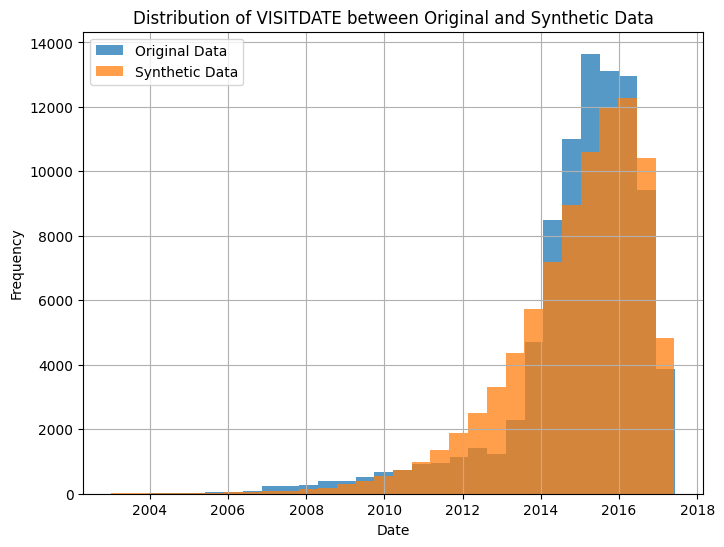

In [326]:
visits_data_original['VISITDATE'] = pd.to_datetime(visits_data_original['VISITDATE'])
visits_data_synthetic['VISITDATE'] = pd.to_datetime(visits_data_synthetic['VISITDATE'])

plt.figure(figsize=(8, 6))
plt.hist(visits_data_original['VISITDATE'], bins=30, alpha=0.75, label='Original Data')
plt.hist(visits_data_synthetic['VISITDATE'], bins=30, alpha=0.75, label='Synthetic Data')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of VISITDATE between Original and Synthetic Data')
plt.legend()
plt.grid(True)
plt.show()

In [327]:
statistics_original = visits_data['VISITDATE'].describe()
statistics_synthetic = visits_data_synthetic['VISITDATE'].describe()
print("Descriptive Statistics - Original Data:")
print(statistics_original)
print("\nDescriptive Statistics - Synthetic Data:")
print(statistics_synthetic)


Descriptive Statistics - Original Data:
count                            88958
mean     2014-12-18 03:37:15.077227520
min                2003-01-07 00:00:00
25%                2014-06-04 00:00:00
50%                2015-04-30 00:00:00
75%                2016-02-18 00:00:00
max                2017-06-06 00:00:00
Name: VISITDATE, dtype: object

Descriptive Statistics - Synthetic Data:
count                            88958
mean     2014-11-21 02:55:29.265496320
min                2003-01-07 00:00:00
25%                2014-01-06 00:00:00
50%                2015-04-13 00:00:00
75%                2016-03-06 00:00:00
max                2017-06-01 00:00:00
Name: VISITDATE, dtype: object


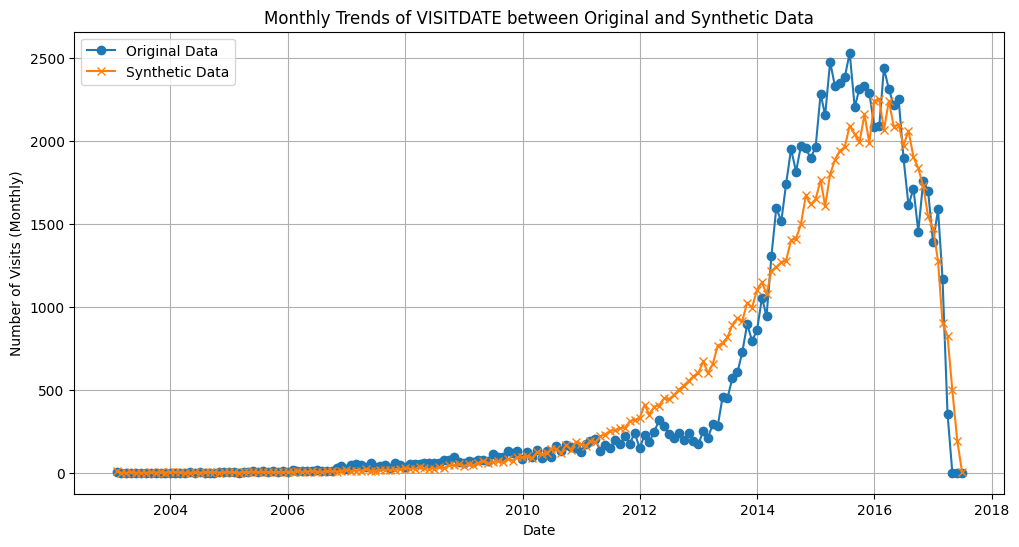

In [328]:
visits_data_original_monthly = visits_data_original.set_index('VISITDATE').resample('M').size()
visits_data_synthetic_monthly = visits_data_synthetic.set_index('VISITDATE').resample('M').size()

plt.figure(figsize=(12, 6))
plt.plot(visits_data_original_monthly.index, visits_data_original_monthly, label='Original Data', marker='o')
plt.plot(visits_data_synthetic_monthly.index, visits_data_synthetic_monthly, label='Synthetic Data', marker='x')
plt.xlabel('Date')
plt.ylabel('Number of Visits (Monthly)')
plt.title('Monthly Trends of VISITDATE between Original and Synthetic Data')
plt.legend()
plt.grid(True)
plt.show()


In [329]:
visits_data_original['VISITDATE_ordinal'] = visits_data_original['VISITDATE'].map(pd.Timestamp.toordinal)
visits_data_synthetic['VISITDATE_ordinal'] = visits_data_synthetic['VISITDATE'].map(pd.Timestamp.toordinal)

variance_original = visits_data_original['VISITDATE_ordinal'].var()
variance_synthetic = visits_data_synthetic['VISITDATE_ordinal'].var()

variance_difference = variance_original - variance_synthetic
percentage_difference = (variance_difference / variance_original) * 100

print(f"Variance - Original Data: {variance_original:.2f}")
print(f"Variance - Synthetic Data: {variance_synthetic:.2f}")
print(f"Difference in Variance: {variance_difference:.2f}")
print(f"Difference in Variance (%): {percentage_difference:.2f}%")

visits_data_original.drop(columns=['VISITDATE_ordinal'], inplace=True)
visits_data_synthetic.drop(columns=['VISITDATE_ordinal'], inplace=True)


Variance - Original Data: 425964.27
Variance - Synthetic Data: 411006.42
Difference in Variance: 14957.85
Difference in Variance (%): 3.51%


Comparison between visits synthetic to original - plots & statistic test

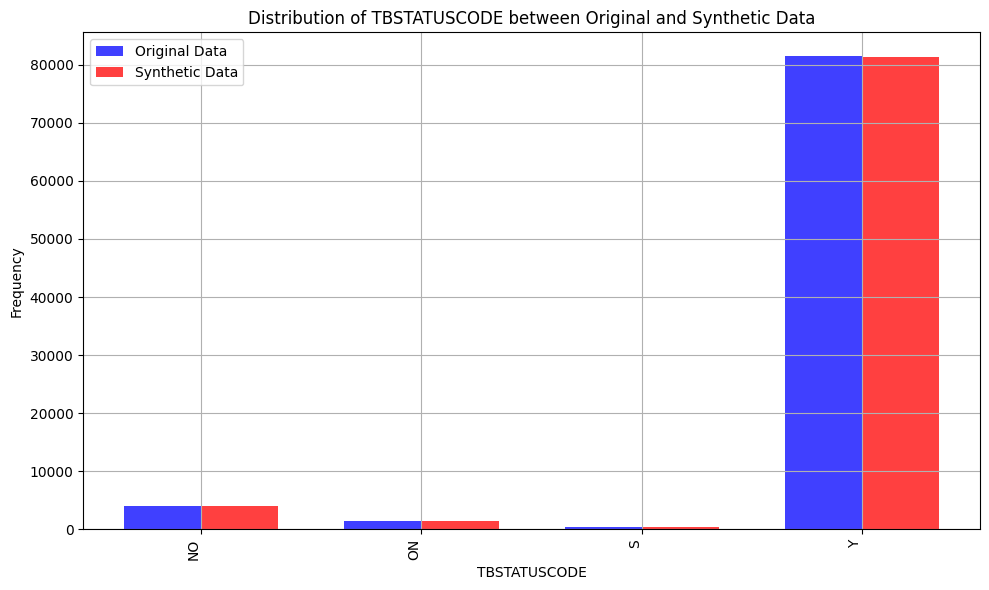


Chi-square Statistic for TBSTATUSCODE: 5.57
P-Value for TBSTATUSCODE: 0.7823



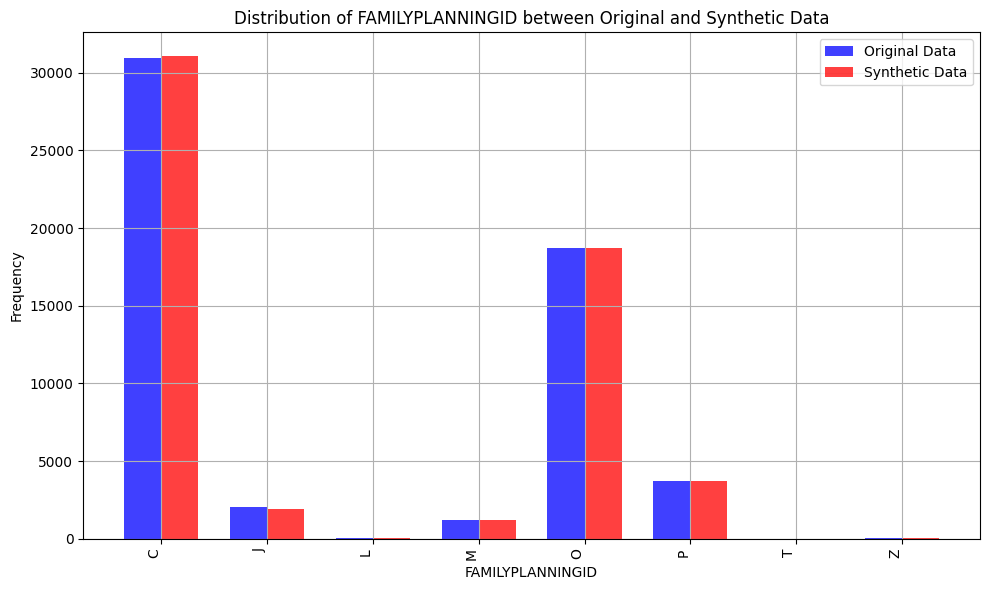


Chi-square Statistic for FAMILYPLANNINGID: 66.91
P-Value for FAMILYPLANNINGID: 0.0454



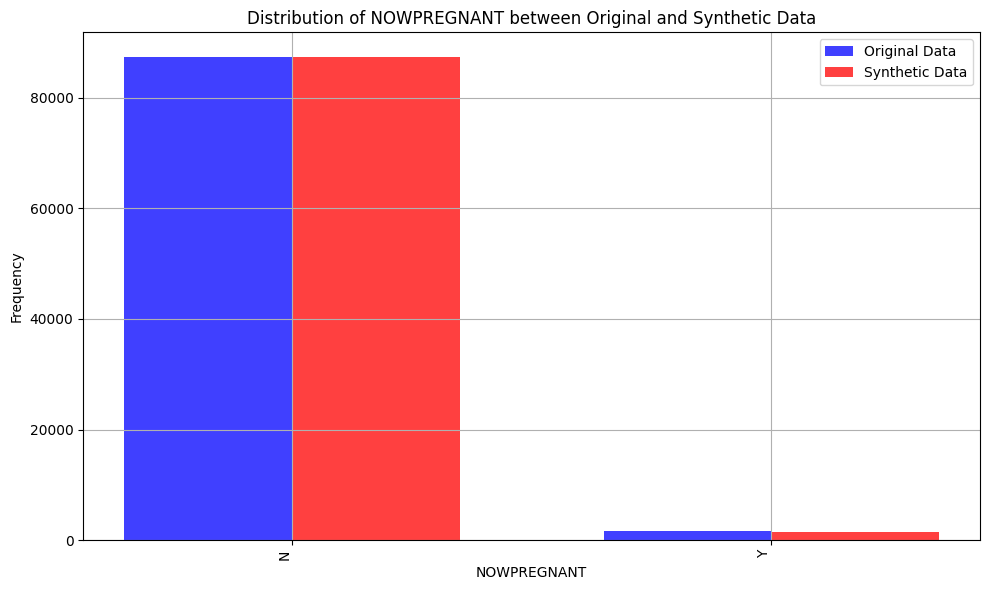


Chi-square Statistic for NOWPREGNANT: 0.53
P-Value for NOWPREGNANT: 0.4651



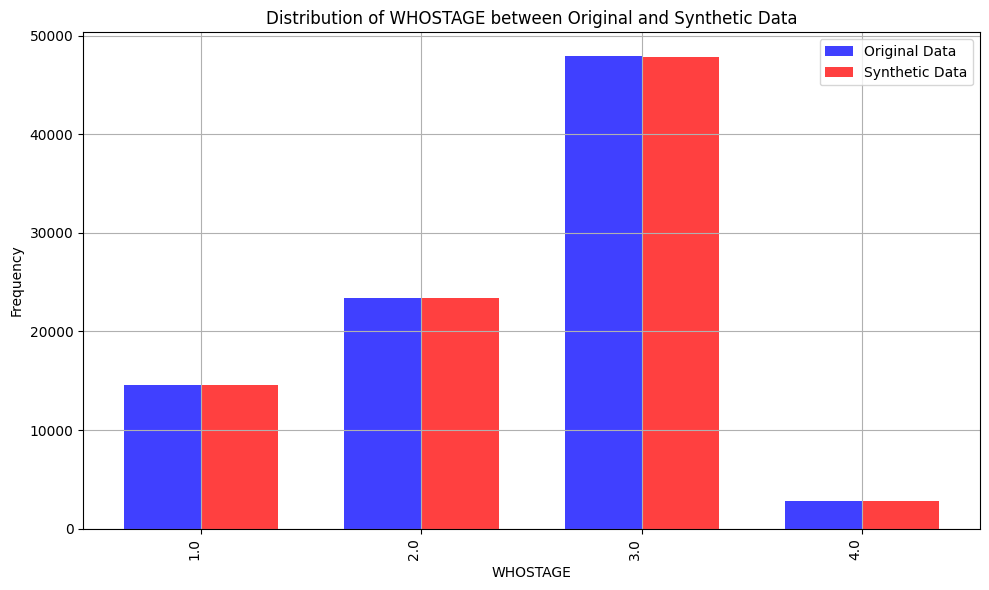


Chi-square Statistic for WHOSTAGE: 4.55
P-Value for WHOSTAGE: 0.8715



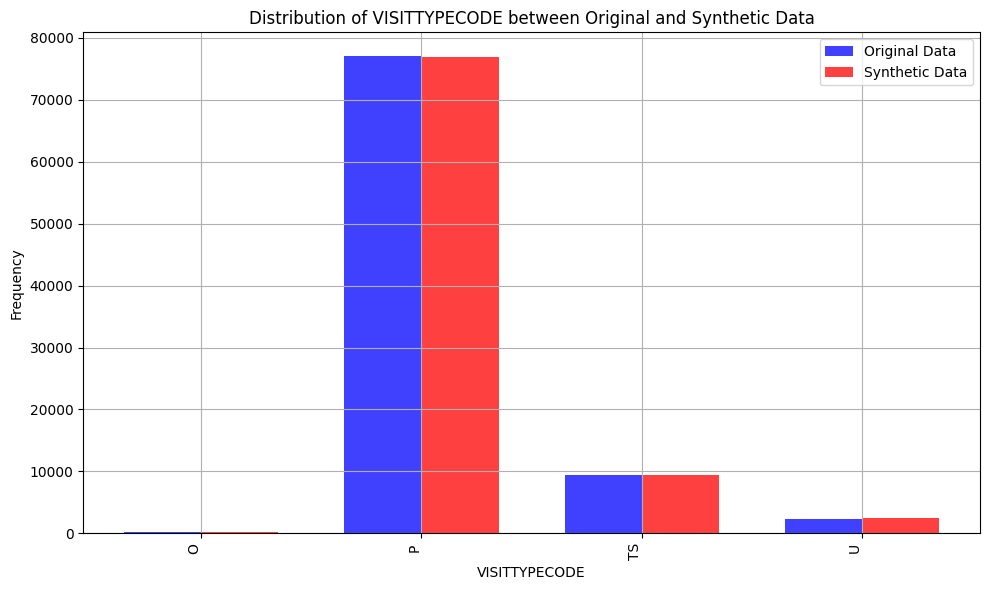


Chi-square Statistic for VISITTYPECODE: 11.44
P-Value for VISITTYPECODE: 0.2469



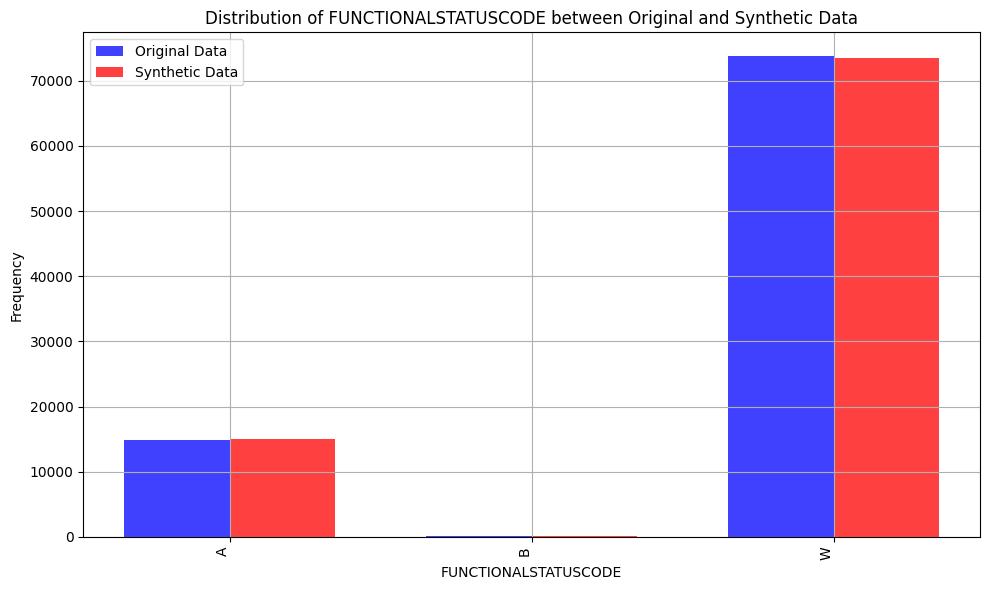


Chi-square Statistic for FUNCTIONALSTATUSCODE: 6.67
P-Value for FUNCTIONALSTATUSCODE: 0.1546



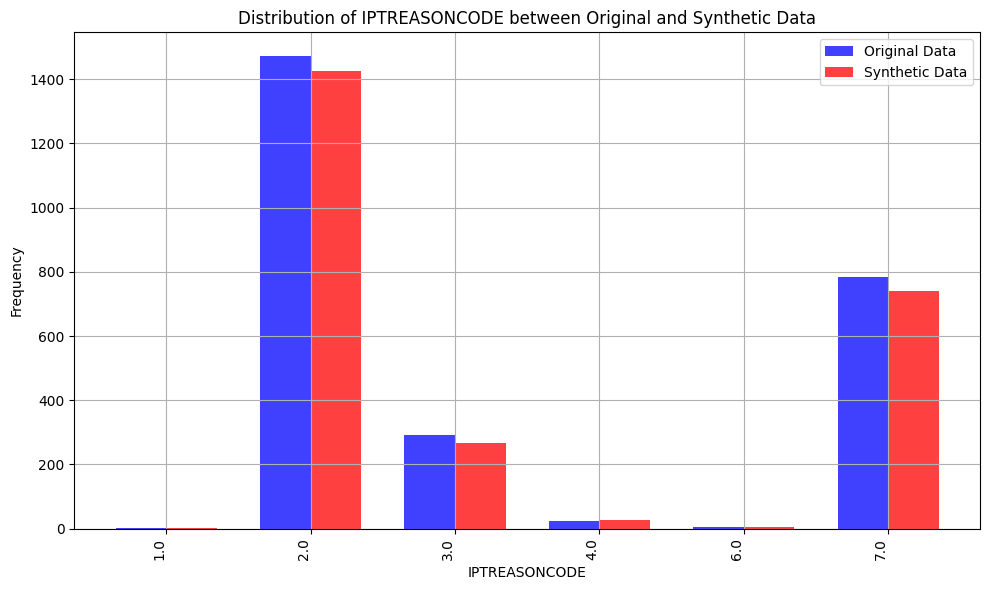


Chi-square Statistic for IPTREASONCODE: 7.10
P-Value for IPTREASONCODE: 0.8507



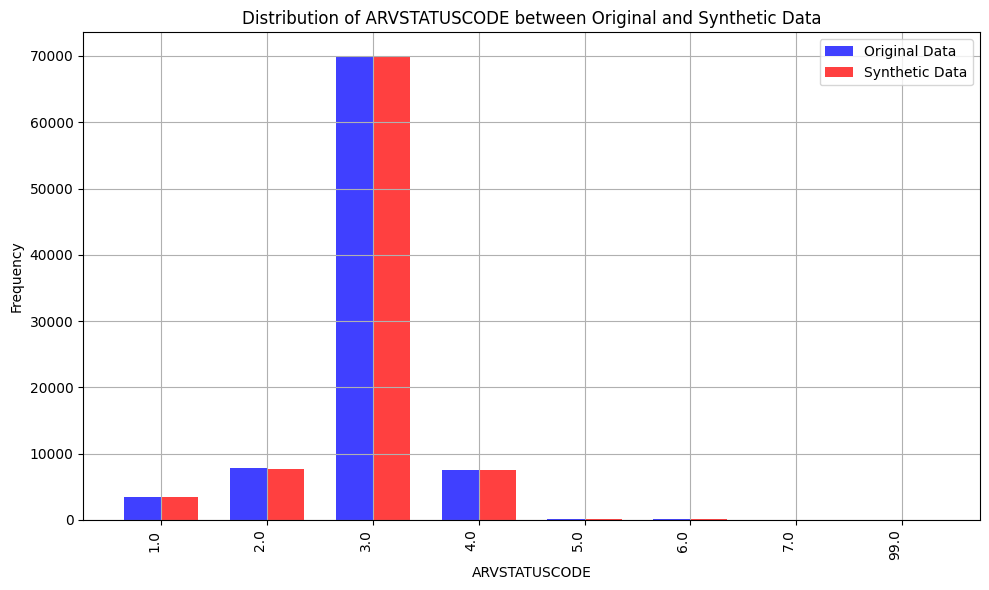


Chi-square Statistic for ARVSTATUSCODE: 62.67
P-Value for ARVSTATUSCODE: 0.0908



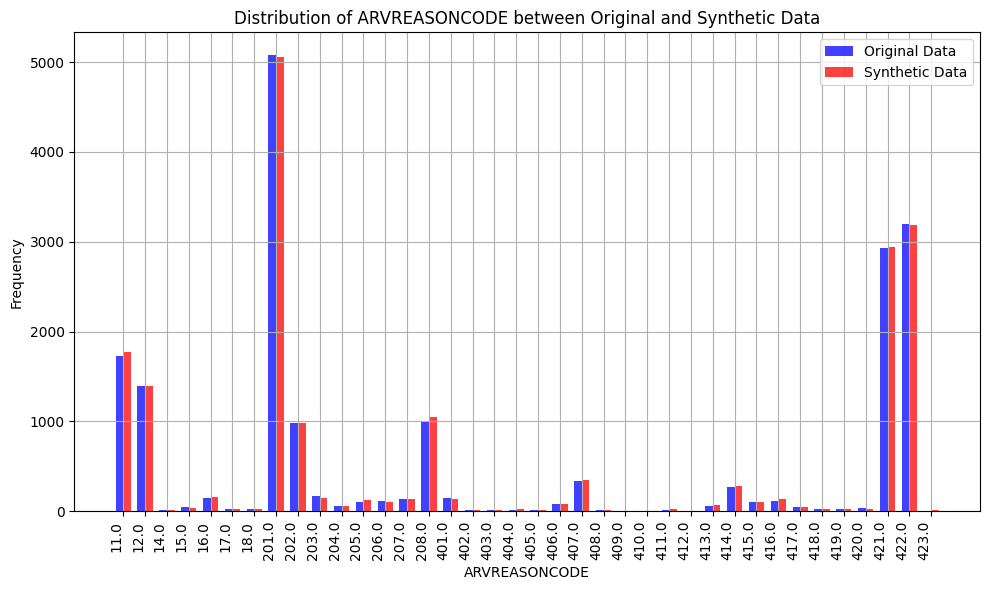


Chi-square Statistic for ARVREASONCODE: 898.68
P-Value for ARVREASONCODE: 1.0000



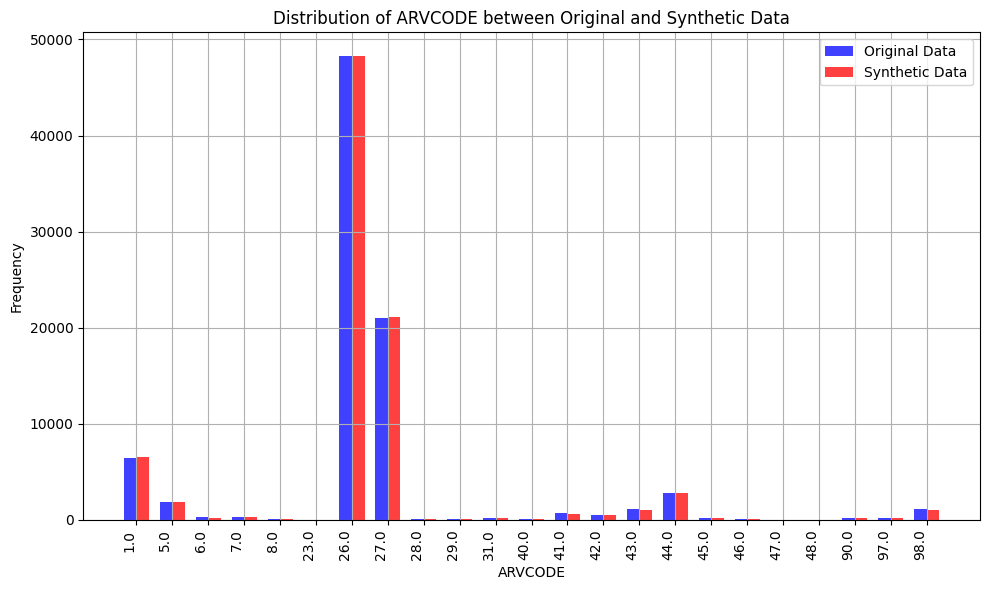


Chi-square Statistic for ARVCODE: 503.19
P-Value for ARVCODE: 0.2642



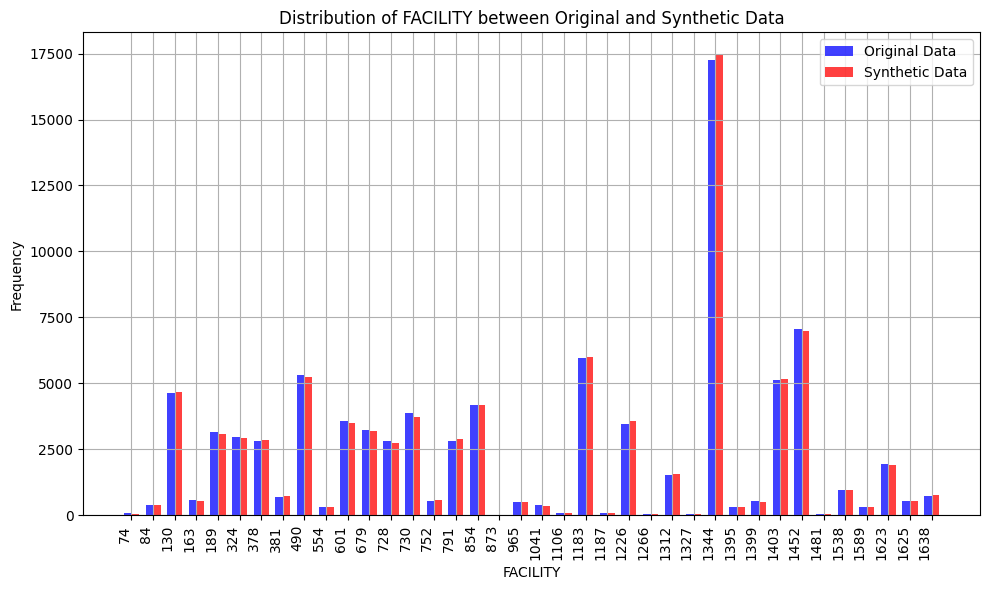


Chi-square Statistic for FACILITY: 1332.87
P-Value for FACILITY: 0.7530



In [331]:
def plot_and_chi2_for_columns(df_original, df_synthetic, columns):
    for column in columns:
        original_counts = df_original[column].value_counts().sort_index()
        synthetic_counts = df_synthetic[column].value_counts().sort_index()

        all_indices = original_counts.index.union(synthetic_counts.index)
        original_counts = original_counts.reindex(all_indices, fill_value=0)
        synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

        bar_width = 0.35
        index = np.arange(len(all_indices))

        fig, ax = plt.subplots(figsize=(10, 6))

        bar1 = ax.bar(index, original_counts, bar_width, alpha=0.75, color='b', label='Original Data')
        bar2 = ax.bar(index + bar_width, synthetic_counts, bar_width, alpha=0.75, color='r', label='Synthetic Data')

        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {column} between Original and Synthetic Data')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(all_indices, rotation=90, ha='right')
        ax.legend()

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        contingency_table = pd.crosstab(df_original[column], df_synthetic[column])

        chi2, p, _, _ = chi2_contingency(contingency_table)

        print(f"\nChi-square Statistic for {column}: {chi2:.2f}")
        print(f"P-Value for {column}: {p:.4f}\n")

columns_to_check = ['TBSTATUSCODE', 'FAMILYPLANNINGID', 'NOWPREGNANT','WHOSTAGE','VISITTYPECODE','FUNCTIONALSTATUSCODE','IPTREASONCODE',
                    'ARVSTATUSCODE','ARVREASONCODE','ARVCODE','FACILITY']
plot_and_chi2_for_columns(visits_data_original, visits_data_synthetic, columns_to_check)


### Test Data comparison

In [333]:
test_data_original.head(1)

,ID,PATIENTID,TESTTYPEID,TESTDATE,RESULTDATE,RESULTNUMERIC,RESULTNOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_ID
0,261411,01-04-0A-2009-A-00726,ALT,2009-06-30,2009-06-30,0.127263,NaN,01040A1,601,2017-05-11,01-04-0A-2009-A-00726_2009-06-30,01-04-0A-2009-A-00726_2009-06-30_261411


In [334]:
test_data_synthetic.head(1)

,ID,PATIENTID,TESTTYPEID,TESTDATE,RESULTDATE,RESULTNUMERIC,RESULTNOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_ID
0,sdv-id-PieMgB,00-00-0A-0000-A-02352,WGT,2015-12-25,2016-01-06,1.0,Back security truth agree them. Likely coach c...,309261,189,2017-06-20,00-00-0A-0000-A-00000_00-24-9258,00-00-0A-0000-A-00000_00-00-0000_1242


COMPARISON PATIENTID

In [336]:
def levenshtein_distance(s1, s2):
    return Levenshtein.distance(s1, s2)

distances = [levenshtein_distance(s1, s2) for s1, s2 in zip(test_data_original['PATIENTID'], test_data_synthetic['PATIENTID'])]

test_data_original['Levenshtein_distance'] = distances
test_data_synthetic['Levenshtein_distance'] = distances

average_distance_original = test_data_original['Levenshtein_distance'].mean()
average_distance_synthetic = test_data_synthetic['Levenshtein_distance'].mean()

print(f"\nAverage Levenshtein Distance - Original Data: {average_distance_original:.2f}")
print(f"Average Levenshtein Distance - Synthetic Data: {average_distance_synthetic:.2f}")



Average Levenshtein Distance - Original Data: 9.75
Average Levenshtein Distance - Synthetic Data: 9.75


Comparison between test synthetic to original - plots & statistic test

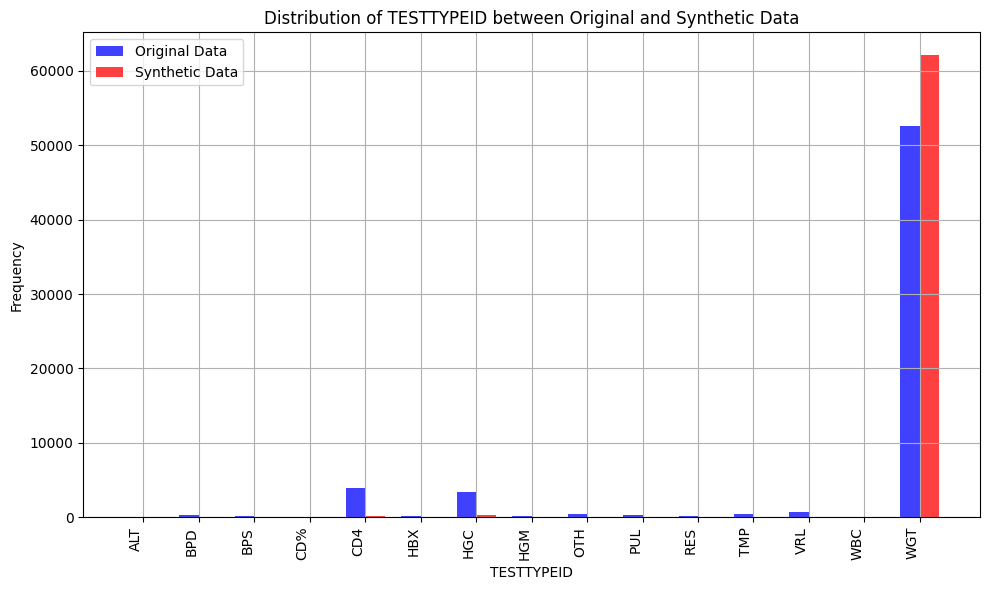


Chi-square Statistic for TESTTYPEID: 127.06
P-Value for TESTTYPEID: 0.9448



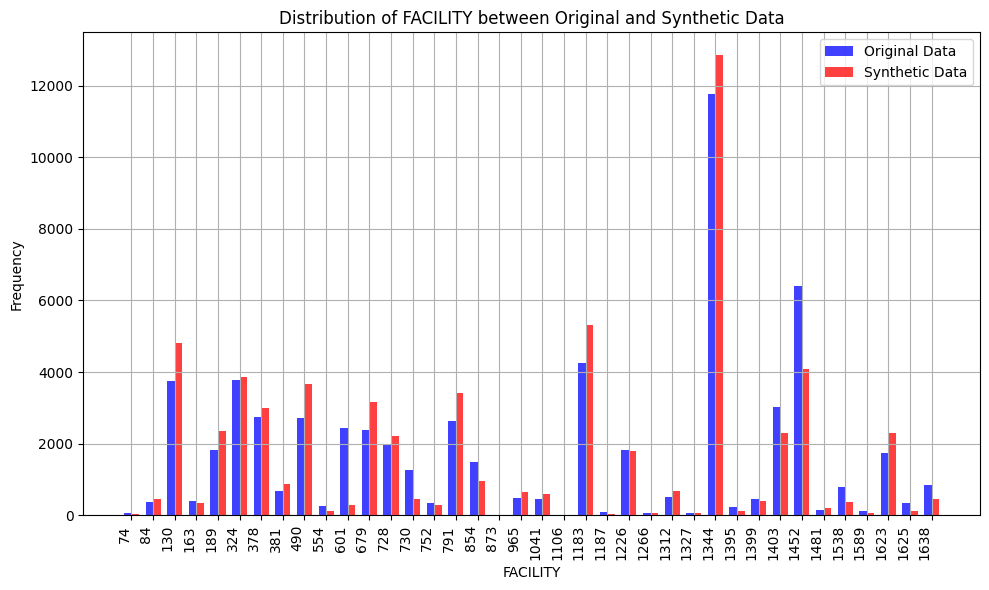


Chi-square Statistic for FACILITY: 1488.47
P-Value for FACILITY: 0.0017



In [338]:
def plot_and_chi2_for_columns(df_original, df_synthetic, columns):
    for column in columns:
        original_counts = df_original[column].value_counts().sort_index()
        synthetic_counts = df_synthetic[column].value_counts().sort_index()

        all_indices = original_counts.index.union(synthetic_counts.index)
        original_counts = original_counts.reindex(all_indices, fill_value=0)
        synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

        bar_width = 0.35
        index = np.arange(len(all_indices))

        fig, ax = plt.subplots(figsize=(10, 6))

        bar1 = ax.bar(index, original_counts, bar_width, alpha=0.75, color='b', label='Original Data')
        bar2 = ax.bar(index + bar_width, synthetic_counts, bar_width, alpha=0.75, color='r', label='Synthetic Data')

        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {column} between Original and Synthetic Data')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(all_indices, rotation=90, ha='right')
        ax.legend()

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        contingency_table = pd.crosstab(df_original[column], df_synthetic[column])

        chi2, p, _, _ = chi2_contingency(contingency_table)

        print(f"\nChi-square Statistic for {column}: {chi2:.2f}")
        print(f"P-Value for {column}: {p:.4f}\n")

columns_to_check = ['TESTTYPEID','FACILITY']
plot_and_chi2_for_columns(test_data_original, test_data_synthetic, columns_to_check)


COMPARISON DATE COLUMNS

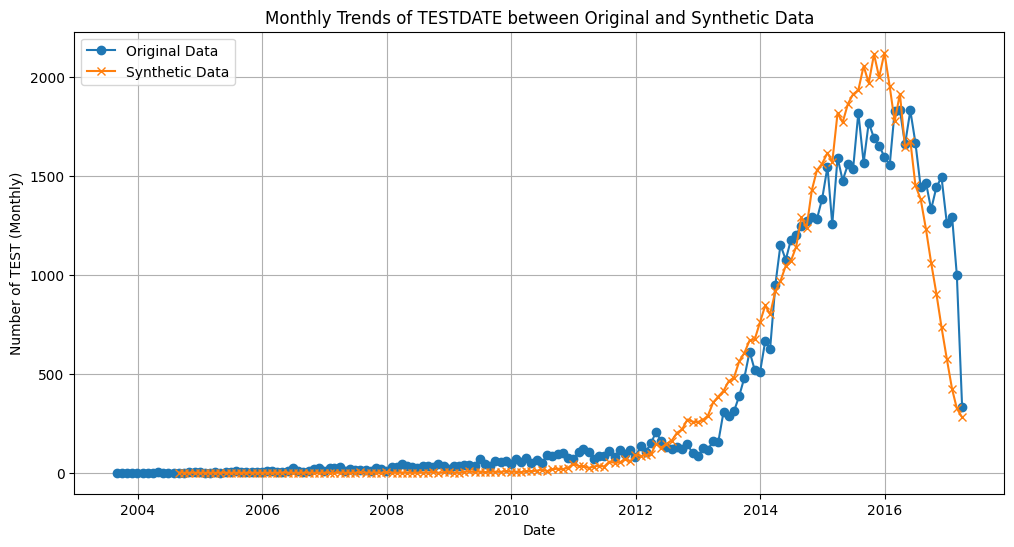

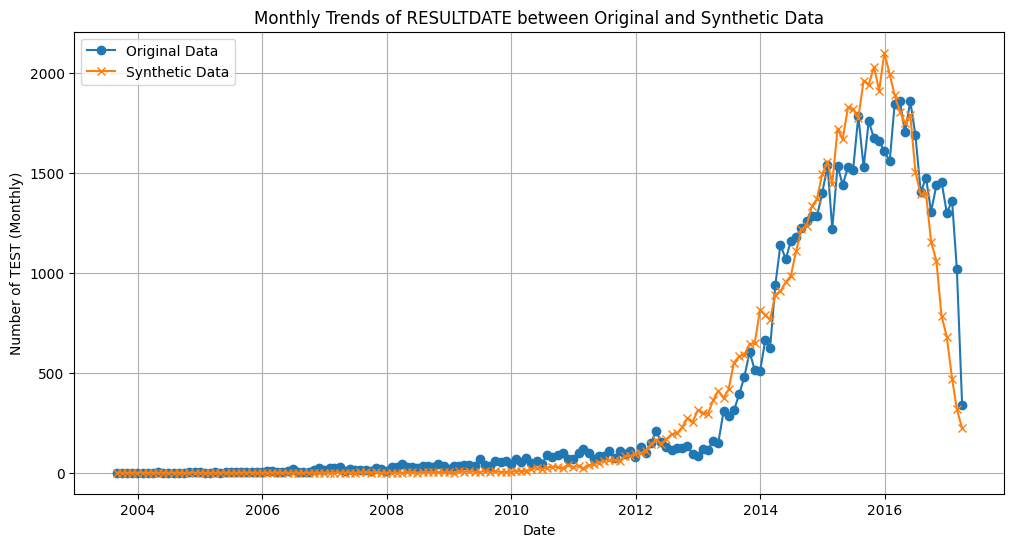

In [340]:
def plot_monthly_trends(data_original, data_synthetic, date_columns):
    for date_column in date_columns:
        data_original[date_column] = pd.to_datetime(data_original[date_column])
        data_synthetic[date_column] = pd.to_datetime(data_synthetic[date_column])

        data_monthly_original = data_original.set_index(date_column).resample('M').size()
        data_monthly_synthetic = data_synthetic.set_index(date_column).resample('M').size()

        plt.figure(figsize=(12, 6))
        plt.plot(data_monthly_original.index, data_monthly_original, label='Original Data', marker='o')
        plt.plot(data_monthly_synthetic.index, data_monthly_synthetic, label='Synthetic Data', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Number of TEST (Monthly)')
        plt.title(f'Monthly Trends of {date_column} between Original and Synthetic Data')
        plt.legend()
        plt.grid(True)
        plt.show()

columns_to_check = ['TESTDATE','RESULTDATE']
plot_monthly_trends(test_data_original, test_data_synthetic,columns_to_check)

COMPARISON RESULTNUMERIC

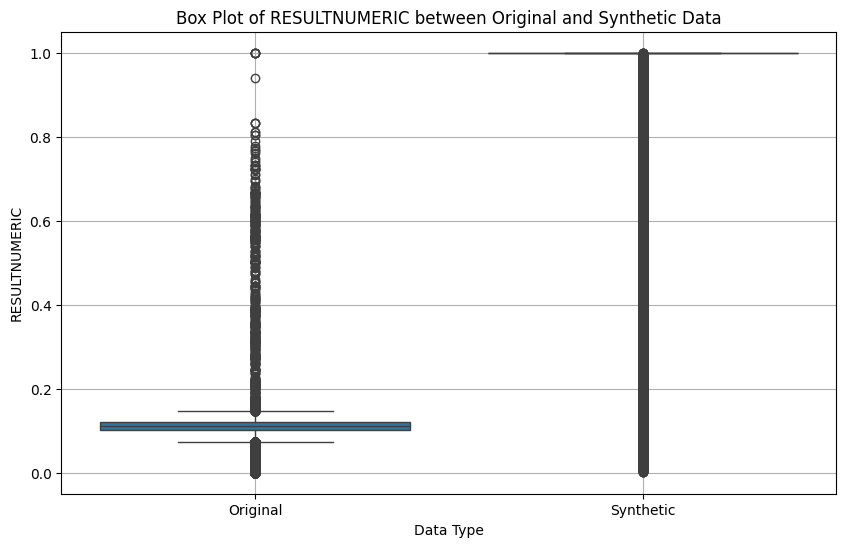

In [342]:
combined_data = pd.DataFrame({
    'RESULTNUMERIC': pd.concat([test_data_original['RESULTNUMERIC'], test_data_synthetic['RESULTNUMERIC']]),
    'Type': ['Original'] * len(test_data_original) + ['Synthetic'] * len(test_data_synthetic)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RESULTNUMERIC', data=combined_data)
plt.xlabel('Data Type')
plt.ylabel('RESULTNUMERIC')
plt.title('Box Plot of RESULTNUMERIC between Original and Synthetic Data')
plt.grid(True)
plt.show()



In [343]:
mean_original = test_data_original['RESULTNUMERIC'].mean()
mean_synthetic = test_data_synthetic['RESULTNUMERIC'].mean()
std_original = test_data_original['RESULTNUMERIC'].std()
std_synthetic = test_data_synthetic['RESULTNUMERIC'].std()

print(f"Mean - Original Data: {mean_original:.2f}")
print(f"Mean - Synthetic Data: {mean_synthetic:.2f}")
print(f"Standard Deviation - Original Data: {std_original:.2f}")
print(f"Standard Deviation - Synthetic Data: {std_synthetic:.2f}")

Mean - Original Data: 0.11
Mean - Synthetic Data: 0.85
Standard Deviation - Original Data: 0.05
Standard Deviation - Synthetic Data: 0.30


In [344]:
t_statistic, p_value = stats.ttest_ind(test_data_original['RESULTNUMERIC'], test_data_synthetic['RESULTNUMERIC'], equal_var=False)

print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-Value: {p_value:.4f}")


T-Statistic: -605.96
P-Value: 0.0000


### Medication Data comparison  

In [346]:
medication_data_original.head(1)

,PATIENTID,VISITDATE,DRUGTYPEID,QUANTITYDISPENSED,PERCENTADHERENCE,NOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_DRUGTYPEID
0,03-09-26-2007-A-00974,2007-04-25,COT,14.0,0.0,NaN,0309261,1344,2017-06-04,03-09-26-2007-A-00974_2007-04-25,03-09-26-2007-A-00974_2007-04-25_COT


In [347]:
medication_data_synthetic.head(1)

,PATIENTID,VISITDATE,DRUGTYPEID,QUANTITYDISPENSED,PERCENTADHERENCE,NOTES,IMPORTFILE,FACILITY,ENTRY_DATE,PATIENTID_VISITDATE,PATIENTID_VISITDATE_DRUGTYPEID
0,00-00-0A-0000-A-00002,2015-10-10,FLU,31.0,8.0,Relate test discover soldier wonder. Party act...,08070C1,1183,2017-06-05,00-00-0A-0000-A-00000_00-24-9258,00-00-0A-0000-A-00000_00-00-0000_C


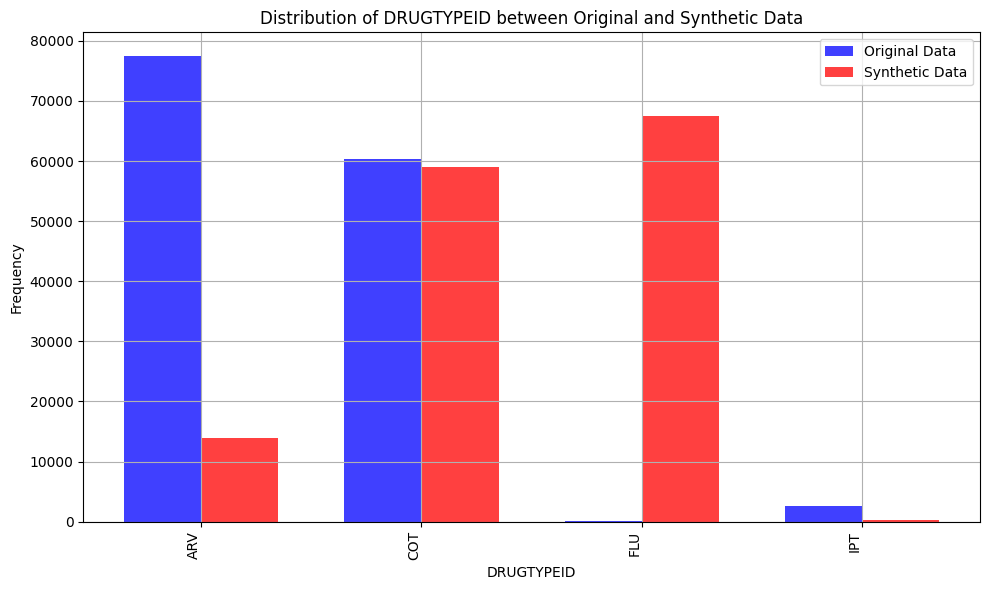


Chi-square Statistic for DRUGTYPEID: 6.35
P-Value for DRUGTYPEID: 0.7043



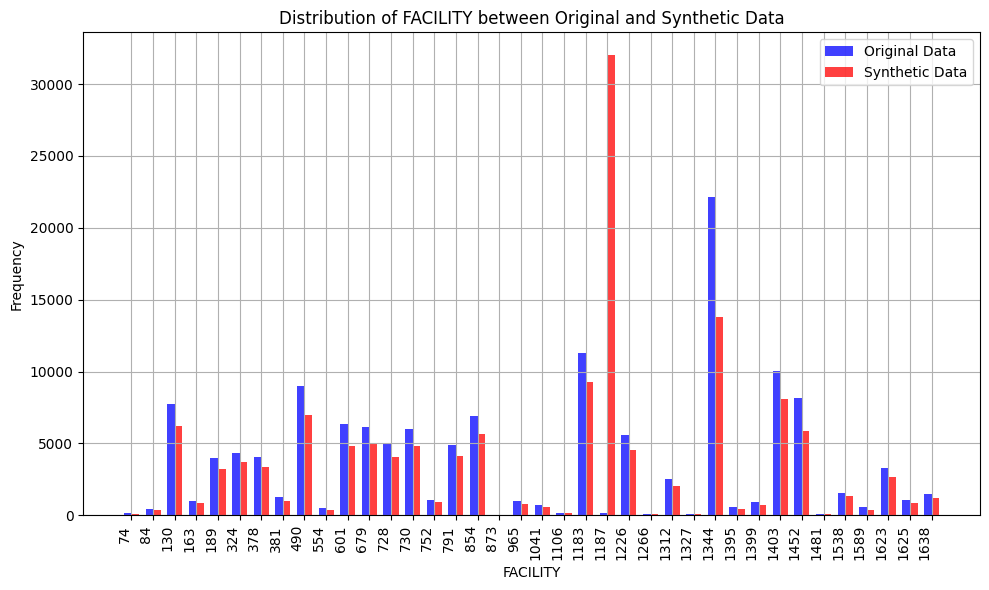


Chi-square Statistic for FACILITY: 2395.88
P-Value for FACILITY: 0.0000



In [348]:
def plot_and_chi2_for_columns(df_original, df_synthetic, columns):
    for column in columns:
        original_counts = df_original[column].value_counts().sort_index()
        synthetic_counts = df_synthetic[column].value_counts().sort_index()

        all_indices = original_counts.index.union(synthetic_counts.index)
        original_counts = original_counts.reindex(all_indices, fill_value=0)
        synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

        bar_width = 0.35
        index = np.arange(len(all_indices))

        fig, ax = plt.subplots(figsize=(10, 6))

        bar1 = ax.bar(index, original_counts, bar_width, alpha=0.75, color='b', label='Original Data')
        bar2 = ax.bar(index + bar_width, synthetic_counts, bar_width, alpha=0.75, color='r', label='Synthetic Data')

        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {column} between Original and Synthetic Data')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(all_indices, rotation=90, ha='right')
        ax.legend()

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        contingency_table = pd.crosstab(df_original[column], df_synthetic[column])

        chi2, p, _, _ = chi2_contingency(contingency_table)

        print(f"\nChi-square Statistic for {column}: {chi2:.2f}")
        print(f"P-Value for {column}: {p:.4f}\n")

columns_to_check = ['DRUGTYPEID','FACILITY']
plot_and_chi2_for_columns(medication_data_original, medication_data_synthetic, columns_to_check)


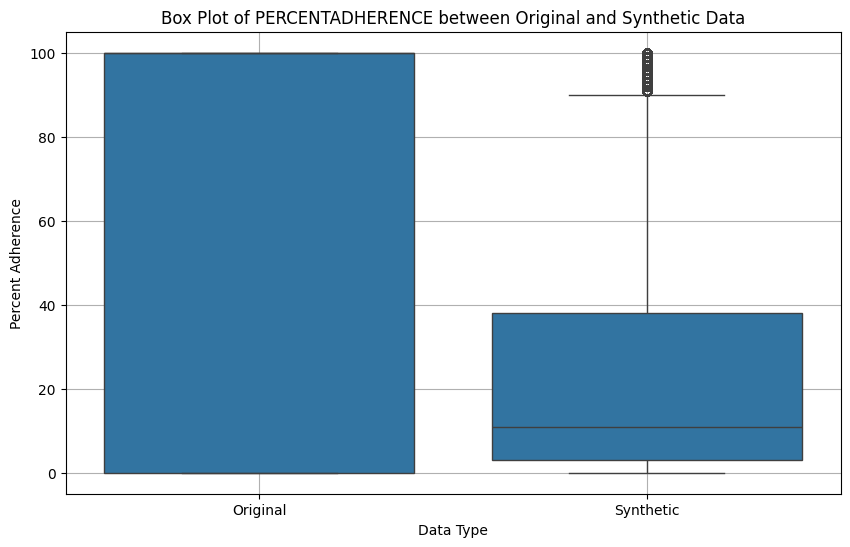

In [349]:
combined_data = pd.DataFrame({
    'PERCENTADHERENCE': pd.concat([medication_data_original['PERCENTADHERENCE'], medication_data_synthetic['PERCENTADHERENCE']]),
    'Type': ['Original'] * len(medication_data_original) + ['Synthetic'] * len(medication_data_synthetic)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='PERCENTADHERENCE', data=combined_data)
plt.xlabel('Data Type')
plt.ylabel('Percent Adherence')
plt.title('Box Plot of PERCENTADHERENCE between Original and Synthetic Data')
plt.grid(True)
plt.show()

In [350]:
mean_original = medication_data_original['PERCENTADHERENCE'].mean()
mean_synthetic = medication_data_synthetic['PERCENTADHERENCE'].mean()
std_original = medication_data_original['PERCENTADHERENCE'].std()
std_synthetic = medication_data_synthetic['PERCENTADHERENCE'].std()

print(f"Mean - Original Data: {mean_original:.2f}")
print(f"Mean - Synthetic Data: {mean_synthetic:.2f}")
print(f"Standard Deviation - Original Data: {std_original:.2f}")
print(f"Standard Deviation - Synthetic Data: {std_synthetic:.2f}")

Mean - Original Data: 65.18
Mean - Synthetic Data: 26.25
Standard Deviation - Original Data: 47.46
Standard Deviation - Synthetic Data: 32.14


In [351]:
t_statistic, p_value = stats.ttest_ind(medication_data_original['PERCENTADHERENCE'], medication_data_original['PERCENTADHERENCE'], equal_var=False)

print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-Value: {p_value:.4f}")


T-Statistic: 0.00
P-Value: 1.0000
